# Импорты

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 4.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [29]:
from dotenv import load_dotenv
load_dotenv()

False

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import spacy

from collections import defaultdict, Counter
from datasets import load_dataset, concatenate_datasets
from wordcloud import WordCloud
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
import math

# Если еще не скачаны стоп-слова:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from spacy.matcher import Matcher

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayuschenikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Описание датасета CrossNER

**Источник:** [Статья (PDF)](https://arxiv.org/pdf/2012.04373)

Датасет **CrossNER** разработан для оценки и изучения способности моделей распознавания именованных сущностей (NER) к обобщению между различными доменами. Он содержит данные из шести областей (доменных подсекций), извлечённые из английской Википедии, а также включает классический набор данных CoNLL2003:

- **AI**: Данные о темах, связанных с искусственным интеллектом.
- **Literature**: Тексты о литературных произведениях, писателях, жанрах.
- **Music**: Материалы о музыке, исполнителях, композициях, жанрах.
- **Politics**: Информация о политиках, политических событиях, партиях.
- **Science**: Данные о научных концептах, учёных, открытиях.
- **CoNLL2003**: Классический эталонный датасет для NER для сравнения.

Каждая доменная подсекция содержит свои специфические типы именованных сущностей, что позволяет оценить способность моделей обобщать знания, полученные в одном домене, на другие.

Структура и особенности датасета:
- Доступны три сплита для каждой доменной подсекции: `train`, `validation`, `test`.
- Набор сущностей и их распределение сильно варьируются от домена к домену.
- Датасет был создан для исследования междоменного переноса и устойчивости NER-моделей. В частности: CoNLL2003 рассматривался как source dataset, a остальные 5 доменов, как target dataset.

![image.png](images/1.png)

**Здесь будет изображение с таблицей статистических характеристик датасета (количество предложений, токенов, сущностей для каждого домена)**

Применение:
- Оценка качества и устойчивости моделей NER при переходе между доменами.
- Изучение влияния доменных различий на результаты распознавания сущностей.
- Разработка более универсальных и обобщающих NER-моделей, способных работать в условиях значительных доменных сдвигов.

ВАЖНО! Так как некоторая оценка и исследование проведено в статье оригинального датасета и их легко "сравнить", давайте попробуем сделать так, чтобы представленные методы метчились в оценками, приведенными в статье. У нас не стоит задача превзойти метрики, представленные там, поскольку нам важно не происследовать перенос с одного домена на другой, а обучить модель, способную на всем представленном датасете (общем) получить похожие метрики и необязательно презвойти их (иначе это не тянет на 2х недельную лабу).

ВАЖНО 2: так как наши одногруппники взяли в рассмотрение одиночный датасет **CoNLL2003**, а он содержится в наших данных мы его не будем выкидывать, но основная наша цель - работать и получать метрики по другим (target) датасетам, однако мы на всякий случай решили оставить **CoNLL2003**, на случай, если содержание этого датасета в наших расширенных данных не вызовет проблем.

# EDA

## Загрузка данных

In [31]:
domains = ["ai", "conll2003", "literature", "music", "politics", "science"]

train_datasets = []
val_datasets = []
test_datasets = []

dataset = {}

for subsection in domains:
    ds = load_dataset("DFKI-SLT/cross_ner", subsection)
    # Добавляем колонку "source"
    ds_train = ds["train"].map(lambda x: {"source": subsection})
    ds_val = ds["validation"].map(lambda x: {"source": subsection})
    ds_test = ds["test"].map(lambda x: {"source": subsection})
    
    # Собираем в списки
    train_datasets.append(ds_train)
    val_datasets.append(ds_val)
    test_datasets.append(ds_test)

# Объединяем все в единые датасеты
dataset["train"] = concatenate_datasets(train_datasets)
dataset["val"] = concatenate_datasets(val_datasets)
dataset["test"] = concatenate_datasets(test_datasets)

Теперь у нас есть три датасета: train_dataset, val_dataset, test_dataset.
Каждый пример содержит колонку "source" с указанием исходной подсекции.

In [32]:
dataset["train"]

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'source'],
    num_rows: 14741
})

## Как выглядят данные?

Рассмотрим первый элемент данных, мы видим, что для каждого элемента данных мы имеем:
- индекс конкретного элемента, 
- токены, которые представляют собой каждое отдельно слово
- уже закодированные теги каждого слов
- источник или домен данных, чтобы понимать, из какого датасета данный конкретный пример

In [33]:
import pandas as pd
pd.DataFrame(dataset["train"][0])

id         tokens  ner_tags source
0   0        Popular         0     ai
1   0     approaches         0     ai
2   0             of         0     ai
3   0  opinion-based        59     ai
4   0    recommender        60     ai
.. ..            ...       ...    ...
59  0              5         0     ai
60  0              )         0     ai
61  0              :         0     ai
62  0         e12957         0     ai
63  0              .         0     ai

[64 rows x 4 columns]

## Анализ для тегов

Давайте поближе посмотрим на кодировку:

### Что это?

In [172]:
tag2id = {"O": 0, "B-academicjournal": 1, "I-academicjournal": 2, "B-album": 3, "I-album": 4, "B-algorithm": 5, "I-algorithm": 6, "B-astronomicalobject": 7, "I-astronomicalobject": 8, "B-award": 9, "I-award": 10, "B-band": 11, "I-band": 12, "B-book": 13, "I-book": 14, "B-chemicalcompound": 15, "I-chemicalcompound": 16, "B-chemicalelement": 17, "I-chemicalelement": 18, "B-conference": 19, "I-conference": 20, "B-country": 21, "I-country": 22, "B-discipline": 23, "I-discipline": 24, "B-election": 25, "I-election": 26, "B-enzyme": 27, "I-enzyme": 28, "B-event": 29, "I-event": 30, "B-field": 31, "I-field": 32, "B-literarygenre": 33, "I-literarygenre": 34, "B-location": 35, "I-location": 36, "B-magazine": 37, "I-magazine": 38, "B-metrics": 39, "I-metrics": 40, "B-misc": 41, "I-misc": 42, "B-musicalartist": 43, "I-musicalartist": 44, "B-musicalinstrument": 45, "I-musicalinstrument": 46, "B-musicgenre": 47, "I-musicgenre": 48, "B-organisation": 49, "I-organisation": 50, "B-person": 51, "I-person": 52, "B-poem": 53, "I-poem": 54, "B-politicalparty": 55, "I-politicalparty": 56, "B-politician": 57, "I-politician": 58, "B-product": 59, "I-product": 60, "B-programlang": 61, "I-programlang": 62, "B-protein": 63, "I-protein": 64, "B-researcher": 65, "I-researcher": 66, "B-scientist": 67, "I-scientist": 68, "B-song": 69, "I-song": 70, "B-task": 71, "I-task": 72, "B-theory": 73, "I-theory": 74, "B-university": 75, "I-university": 76, "B-writer": 77, "I-writer": 78,  "<PAD>": 79}
id2tag = {id: tag for tag, id in tag2id.items()}
id2tag

{0: 'O',
 1: 'B-academicjournal',
 2: 'I-academicjournal',
 3: 'B-album',
 4: 'I-album',
 5: 'B-algorithm',
 6: 'I-algorithm',
 7: 'B-astronomicalobject',
 8: 'I-astronomicalobject',
 9: 'B-award',
 10: 'I-award',
 11: 'B-band',
 12: 'I-band',
 13: 'B-book',
 14: 'I-book',
 15: 'B-chemicalcompound',
 16: 'I-chemicalcompound',
 17: 'B-chemicalelement',
 18: 'I-chemicalelement',
 19: 'B-conference',
 20: 'I-conference',
 21: 'B-country',
 22: 'I-country',
 23: 'B-discipline',
 24: 'I-discipline',
 25: 'B-election',
 26: 'I-election',
 27: 'B-enzyme',
 28: 'I-enzyme',
 29: 'B-event',
 30: 'I-event',
 31: 'B-field',
 32: 'I-field',
 33: 'B-literarygenre',
 34: 'I-literarygenre',
 35: 'B-location',
 36: 'I-location',
 37: 'B-magazine',
 38: 'I-magazine',
 39: 'B-metrics',
 40: 'I-metrics',
 41: 'B-misc',
 42: 'I-misc',
 43: 'B-musicalartist',
 44: 'I-musicalartist',
 45: 'B-musicalinstrument',
 46: 'I-musicalinstrument',
 47: 'B-musicgenre',
 48: 'I-musicgenre',
 49: 'B-organisation',
 50: 

Мы видим, что для каждой сущности, например сущность писатель (writer) есть две метки: начало метки ('B-writer') и то, что еще находится в этой метке ('I-writer'). Метка 'O' предсталяет из себя лейбл для всех неименнованных сущностей, то есть тех сущностей, которые нас не интересуют. Пример:

In [35]:
example = pd.DataFrame(dataset["train"][0])
example["ners"] = example["ner_tags"].apply(lambda x: id2tag[x])
example[["tokens", "ners", "ner_tags"]].head(10)

tokens       ners  ner_tags
0        Popular          O         0
1     approaches          O         0
2             of          O         0
3  opinion-based  B-product        59
4    recommender  I-product        60
5         system  I-product        60
6        utilize          O         0
7        various          O         0
8     techniques          O         0
9      including          O         0

Таким образом мы понимаем, что `opinion-based recommender system` - это какой-то продукт

### Пересекаются ли лейблы теги между датасетами?

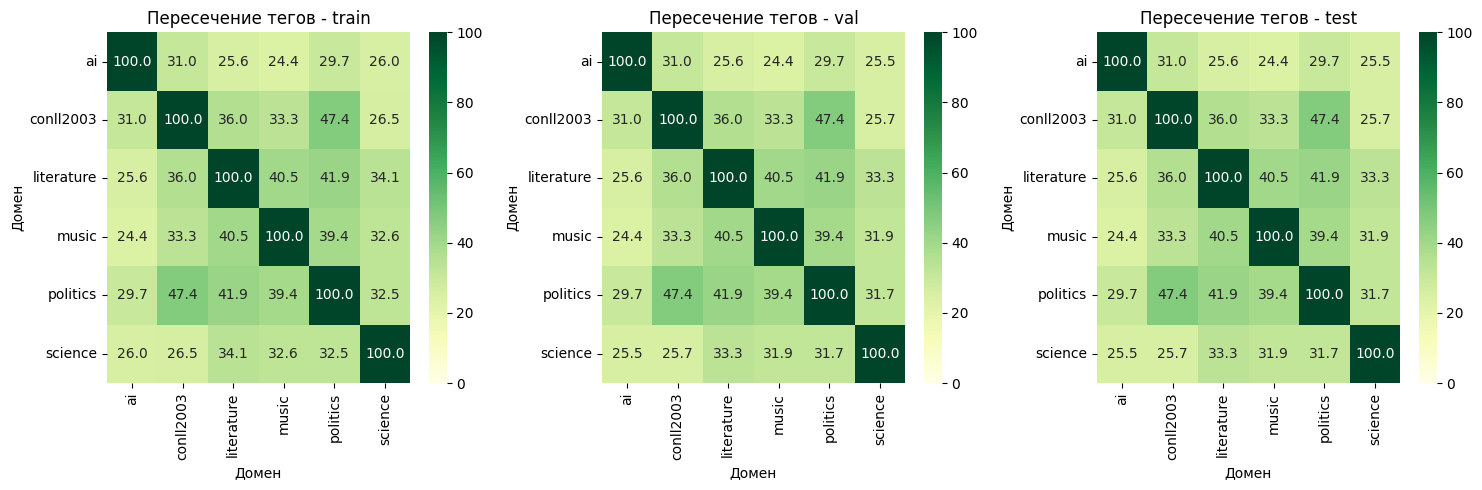

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

domains = ["ai", "conll2003", "literature", "music", "politics", "science"]

def get_domain_tags(dataset, domain_name, with_o=True):
    """
    Извлекает теги для домена.
    """
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    domain_tags = set()
    for ex in domain_examples:
        for tag_id in ex["ner_tags"]:
            if tag_id != 0 or with_o:  # Исключаем тег O, если указано
                domain_tags.add(tag_id)
    return domain_tags

def compute_overlap_matrix(tags_dict):
    """
    Рассчитывает матрицу пересечений между доменами.
    """
    doms = list(tags_dict.keys())
    matrix = pd.DataFrame(index=doms, columns=doms, data=0.0)
    for d1 in doms:
        for d2 in doms:
            set1 = tags_dict[d1]
            set2 = tags_dict[d2]
            intersection = set1.intersection(set2)
            union = set1.union(set2)
            overlap = (len(intersection) / len(union)) * 100 if len(union) > 0 else 0.0
            matrix.loc[d1, d2] = overlap
    return matrix

def plot_heatmaps_grid(overlaps, cols=3):
    """
    Строит тепловые карты пересечения тегов между доменами в виде решётки.
    """
    # Список разбиений (train, val, test)
    splits = list(overlaps.keys())

    # Определяем количество строк и столбцов
    rows = (len(splits) + cols - 1) // cols  # Округление вверх
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, split in enumerate(splits):
        ax = axes[i]
        sns.heatmap(overlaps[split], annot=True, fmt=".1f", cmap="YlGn", vmin=0, vmax=100, ax=ax)
        ax.set_title(f"Пересечение тегов - {split}")
        ax.set_xlabel("Домен")
        ax.set_ylabel("Домен")

    # Удаляем лишние оси
    for j in range(len(splits), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Собираем теги и пересечения
tags = {}
overlaps = {}

for split in dataset.keys():
    tags[split] = {d: get_domain_tags(dataset[split], d) for d in domains}
    overlaps[split] = compute_overlap_matrix(tags[split])

# Строим тепловые карты в виде решётки
plot_heatmaps_grid(overlaps, cols=3)

Важно: мы выбросили здесь тег 'O' потому что данный тег будет присутствовать в каждом домене.

Данные подобраны и разделены так, что в уровень пересечений данных вне зависимости от сплита: train, test и validation мы получаем одинаковое процентное пересечение по тегам. Мы можем заметить, что все перемечения не превышают 50%, что говорит о том, что теги в датасетах имеют существенные отличия друг от дружки в большинстве своем.

Самое больше пересечение в 44.4% наблюдается между `conll2003` и `politics` датасетами, а в `ai` датасете, как и в `science` наблюдаются теги, которые меньше всего пересекаются с остальными доменами.

Сметчим сначала численные теги с именами тегов:

In [37]:
def extract_tag_names(example):
    original_tags = example["ner_tags"]
    
    # Преобразуем ID тегов в их текстовые названия
    tag_names = [id2tag[tag_id] for tag_id in original_tags]
    
    return {"tags_named": tag_names}

for split in dataset.keys():
    dataset[split] = dataset[split].map(extract_tag_names)

Map: 100%|██████████| 5959/5959 [00:00<00:00, 21767.88 examples/s]


In [38]:
from spacy import displacy

def get_sentences_with_specific_misc_tags(dataset, domains):
    """
    Возвращает по одному предложению для каждого домена, где:
    - 100% есть хотя бы "B-misc"
    - ИЛИ есть оба "B-misc" и "I-misc".
    
    Args:
    - dataset (dict): словарь с разделами (train, test, val).
    - domains (list): список доменов.

    Returns:
    - dict: ключи - домены, значения - словарь с предложением и тегами.
    """
    misc_sentences = {}

    for split, data in dataset.items():
        for example in data:
            domain = example["source"]
            if domain in domains and domain not in misc_sentences:
                tokens = example["tokens"]
                tags = example["tags_named"]

                # Условие: 100% есть "B-misc" или оба "B-misc" и "I-misc"
                has_b_misc = "B-misc" in tags
                has_i_misc = "I-misc" in tags

                if has_b_misc or (has_b_misc and has_i_misc):
                    misc_sentences[domain] = {
                        "tokens": tokens,
                        "tags": tags,
                    }

            # Если все домены найдены, остановить поиск
            if len(misc_sentences) == len(domains):
                break

    return misc_sentences
from spacy import displacy

def visualize_sentences_with_displacy_corrected(misc_sentences):
    """
    Визуализирует предложения с тегами "B-misc" или "I-misc" по доменам с использованием SpaCy displacy.
    """
    print("Визуализация предложений с тегами 'B-misc' или 'I-misc':")
    print("=" * 50)

    for domain, info in misc_sentences.items():
        tokens = info["tokens"]
        tags = info["tags"]

        # Формируем текст из токенов
        text = " ".join(tokens)
        entities = []
        current_char_index = 0

        for token, tag in zip(tokens, tags):
            token_length = len(token)
            if tag in {"B-misc", "I-misc"}:
                entities.append({
                    "start": current_char_index,  # Начальная позиция токена в тексте
                    "end": current_char_index + token_length,  # Конечная позиция токена в тексте
                    "label": tag  # Тег токена
                })
            current_char_index += token_length + 1  # Смещаем индекс на длину токена + пробел

        # Подготавливаем объект для визуализации
        doc = {
            "text": text,
            "ents": entities,
            "title": f"Domain: {domain}",
        }

        # Визуализация с использованием displacy
        displacy.render(doc, style="ent", manual=True, jupyter=True)


# Пример использования
domains = ["ai", "conll2003", "literature", "music", "politics", "science"]
misc_examples_highlighted = get_sentences_with_specific_misc_tags(dataset, domains)

# Визуализация
visualize_sentences_with_displacy_corrected(misc_examples_highlighted)

Визуализация предложений с тегами 'B-misc' или 'I-misc':


Таким образом мы видим, что в рамках каждой секции одни и те же теги 'B-misc' или 'I-misc' могут быть связаны с совсем разными словами по семантике: например в ai мы видим "unsupervised methods" что больше может быть отнесено к продукту, во других отраслях это больше представляет собой национальность. А в политике совсем интересный кейс - это обозначение каких-то сущностей как явлений или продуктов, типо музыкального альбома.

Что если мы попытаемся найти общие теги для каждого из доменов?

In [39]:
def get_common_tags_among_domains(dataset, domains):
    """
    Вычисляет общие теги (tags_named), которые присутствуют во всех доменах.

    Args:
    - dataset (dict): словарь с разделами (train, test, val).
    - domains (list): список доменов.

    Returns:
    - set: множество тегов, которые присутствуют во всех доменах.
    """
    # Создаем словарь с уникальными тегами для каждого домена
    tags_per_domain = {domain: set() for domain in domains}

    for split, data in dataset.items():
        for example in data:
            domain = example["source"]
            if domain in domains:
                tags_per_domain[domain].update(example["tags_named"])

    # Находим пересечение всех множеств тегов
    common_tags = set.intersection(*tags_per_domain.values())

    return common_tags


def display_common_tags_table(common_tags):
    """
    Выводит таблицу с общими тегами между доменами.
    """
    print("Общие теги между всеми доменами:")
    print("=" * 50)
    print("\n".join(sorted(common_tags)))
    print("=" * 50)


# Пример использования
domains = ["ai", "conll2003", "literature", "music", "politics", "science"]
common_tags = get_common_tags_among_domains(dataset, domains)

# Красивый вывод
display_common_tags_table(common_tags)


Общие теги между всеми доменами:
B-location
B-misc
B-organisation
B-person
I-location
I-misc
I-organisation
I-person
O


Выходит, что в каждом домене есть тег location, organization, misc, person и понятно O. А что если мы викинем из рассмотрения домент conll2003 (спойлер: по распределению тегов дальше будет видно, что по разнообразию он самый малочисленный)

In [40]:
# Пример использования
common_tags = get_common_tags_among_domains(dataset, ["ai", "literature", "music", "politics", "science"])

# Красивый вывод
display_common_tags_table(common_tags)

Общие теги между всеми доменами:
B-country
B-location
B-misc
B-organisation
B-person
I-country
I-location
I-misc
I-organisation
I-person
O


К списку выше добавилась еще страна, этот тег присутствует в 5 доменах, исключая conll2003

Данные пересечения наводят нас на мысль о том, что модель не будет справляться со всеми замешанными датасетами, потому что на примере misc тега мы увидели, насколько разная семантика может стоять за одной и той же именованной сущностью в разных доменах. Значит, надо рассматривать эти домены независимо друг от друга.

### Распределение тегов по общему датасету

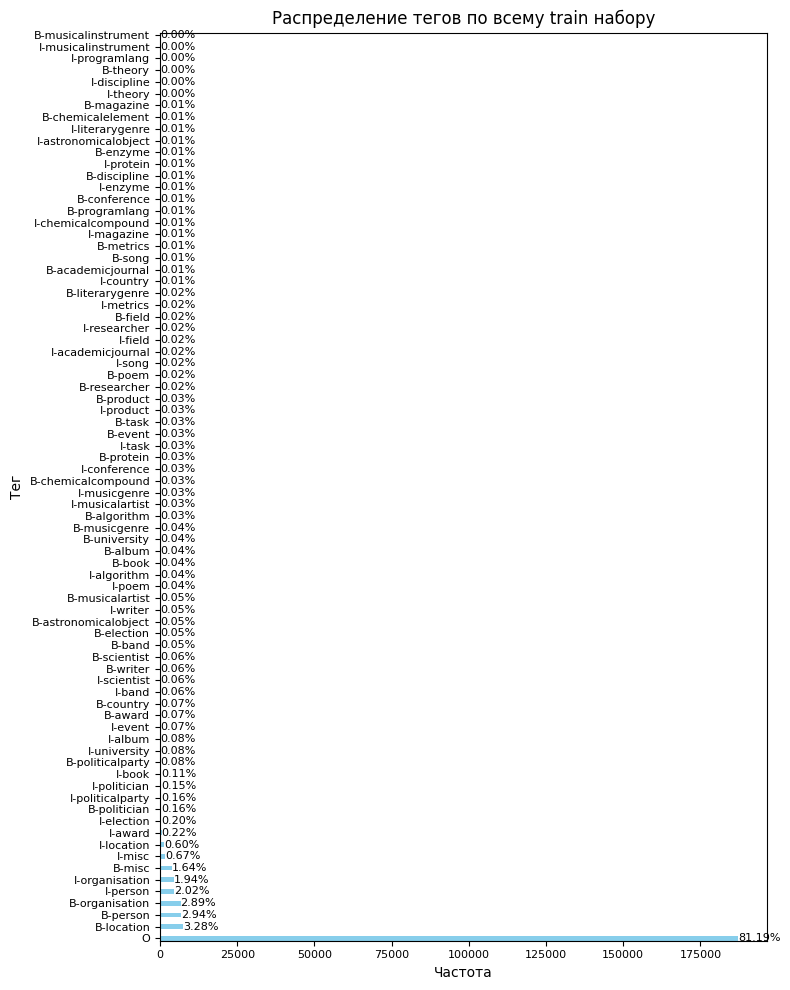

In [41]:
def plot_tag_distribution(df, title):
    # Подсчёт процентов
    total_count = df["count"].sum()
    df["percentage"] = df["count"] / total_count * 100

    # Сортируем
    df = df.sort_values(by="count", ascending=False).reset_index(drop=True)
    
    # Установка фиксированной высоты графика
    fig_height = 10  # Задаём фиксированную высоту
    fig_width = 8    # Ширина графика
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # Уменьшаем высоту баров
    ax.barh(df["tag_id"], df["count"], color="skyblue", height=0.4)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Частота", fontsize=10)
    ax.set_ylabel("Тег", fontsize=10)

    # Добавляем проценты
    for i, row in df.iterrows():
        ax.text(row["count"] + 0.5, i, f"{row['percentage']:.2f}%", va='center', fontsize=8)
    
    # Уменьшаем шрифт подписей осей
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)

    # Уменьшаем отступы сверху и снизу
    plt.margins(y=0)  # Убираем лишние внутренние отступы
    plt.subplots_adjust(top=0.9, bottom=0.1)  # Настраиваем отступы графика
    plt.tight_layout()  # Автоматическая настройка для компактности
    plt.show()


# Пример для всего train набора
all_tags = []
for ex in dataset["train"]:
    all_tags.extend(ex["ner_tags"])

tag_counts = Counter(all_tags)
tag_counts_named = {id2tag[tag_id]: count for tag_id, count in tag_counts.items()}
df_tags = pd.DataFrame(list(tag_counts_named.items()), columns=["tag_id", "count"])

plot_tag_distribution(df_tags, "Распределение тегов по всему train набору")

Здесь мы рассматриваем сейчас только трейн набор, потому что распределение других сплитов не должно сильно отличаться в виду предыдущей картинкы пересечения классов (она одинаковая в каждом сплите). Единственное, что мы можем сразу сказать, так это то, что большинство токенов в обьединенном датасете, а именно 81% - имеют тег 'O', что для нас крайне много. Лишь 20% токенов - наиболее содержательны для нас.

Мы видим, что у нас есть больше половины тегов, который встречаются меньше чем 0.2% от общего числа данных - это очень плохо. Из-за этого сильно повышается вероятность не быть способными распознавать эти теги. Возможно в конечном итоге лучше обучать отдельные модели под каждый класс.

### Распределение тегов по каждому домену

Давайте посмотрим распределение тегов по каждому домену

Filter: 100%|██████████| 14741/14741 [00:00<00:00, 33910.05 examples/s]


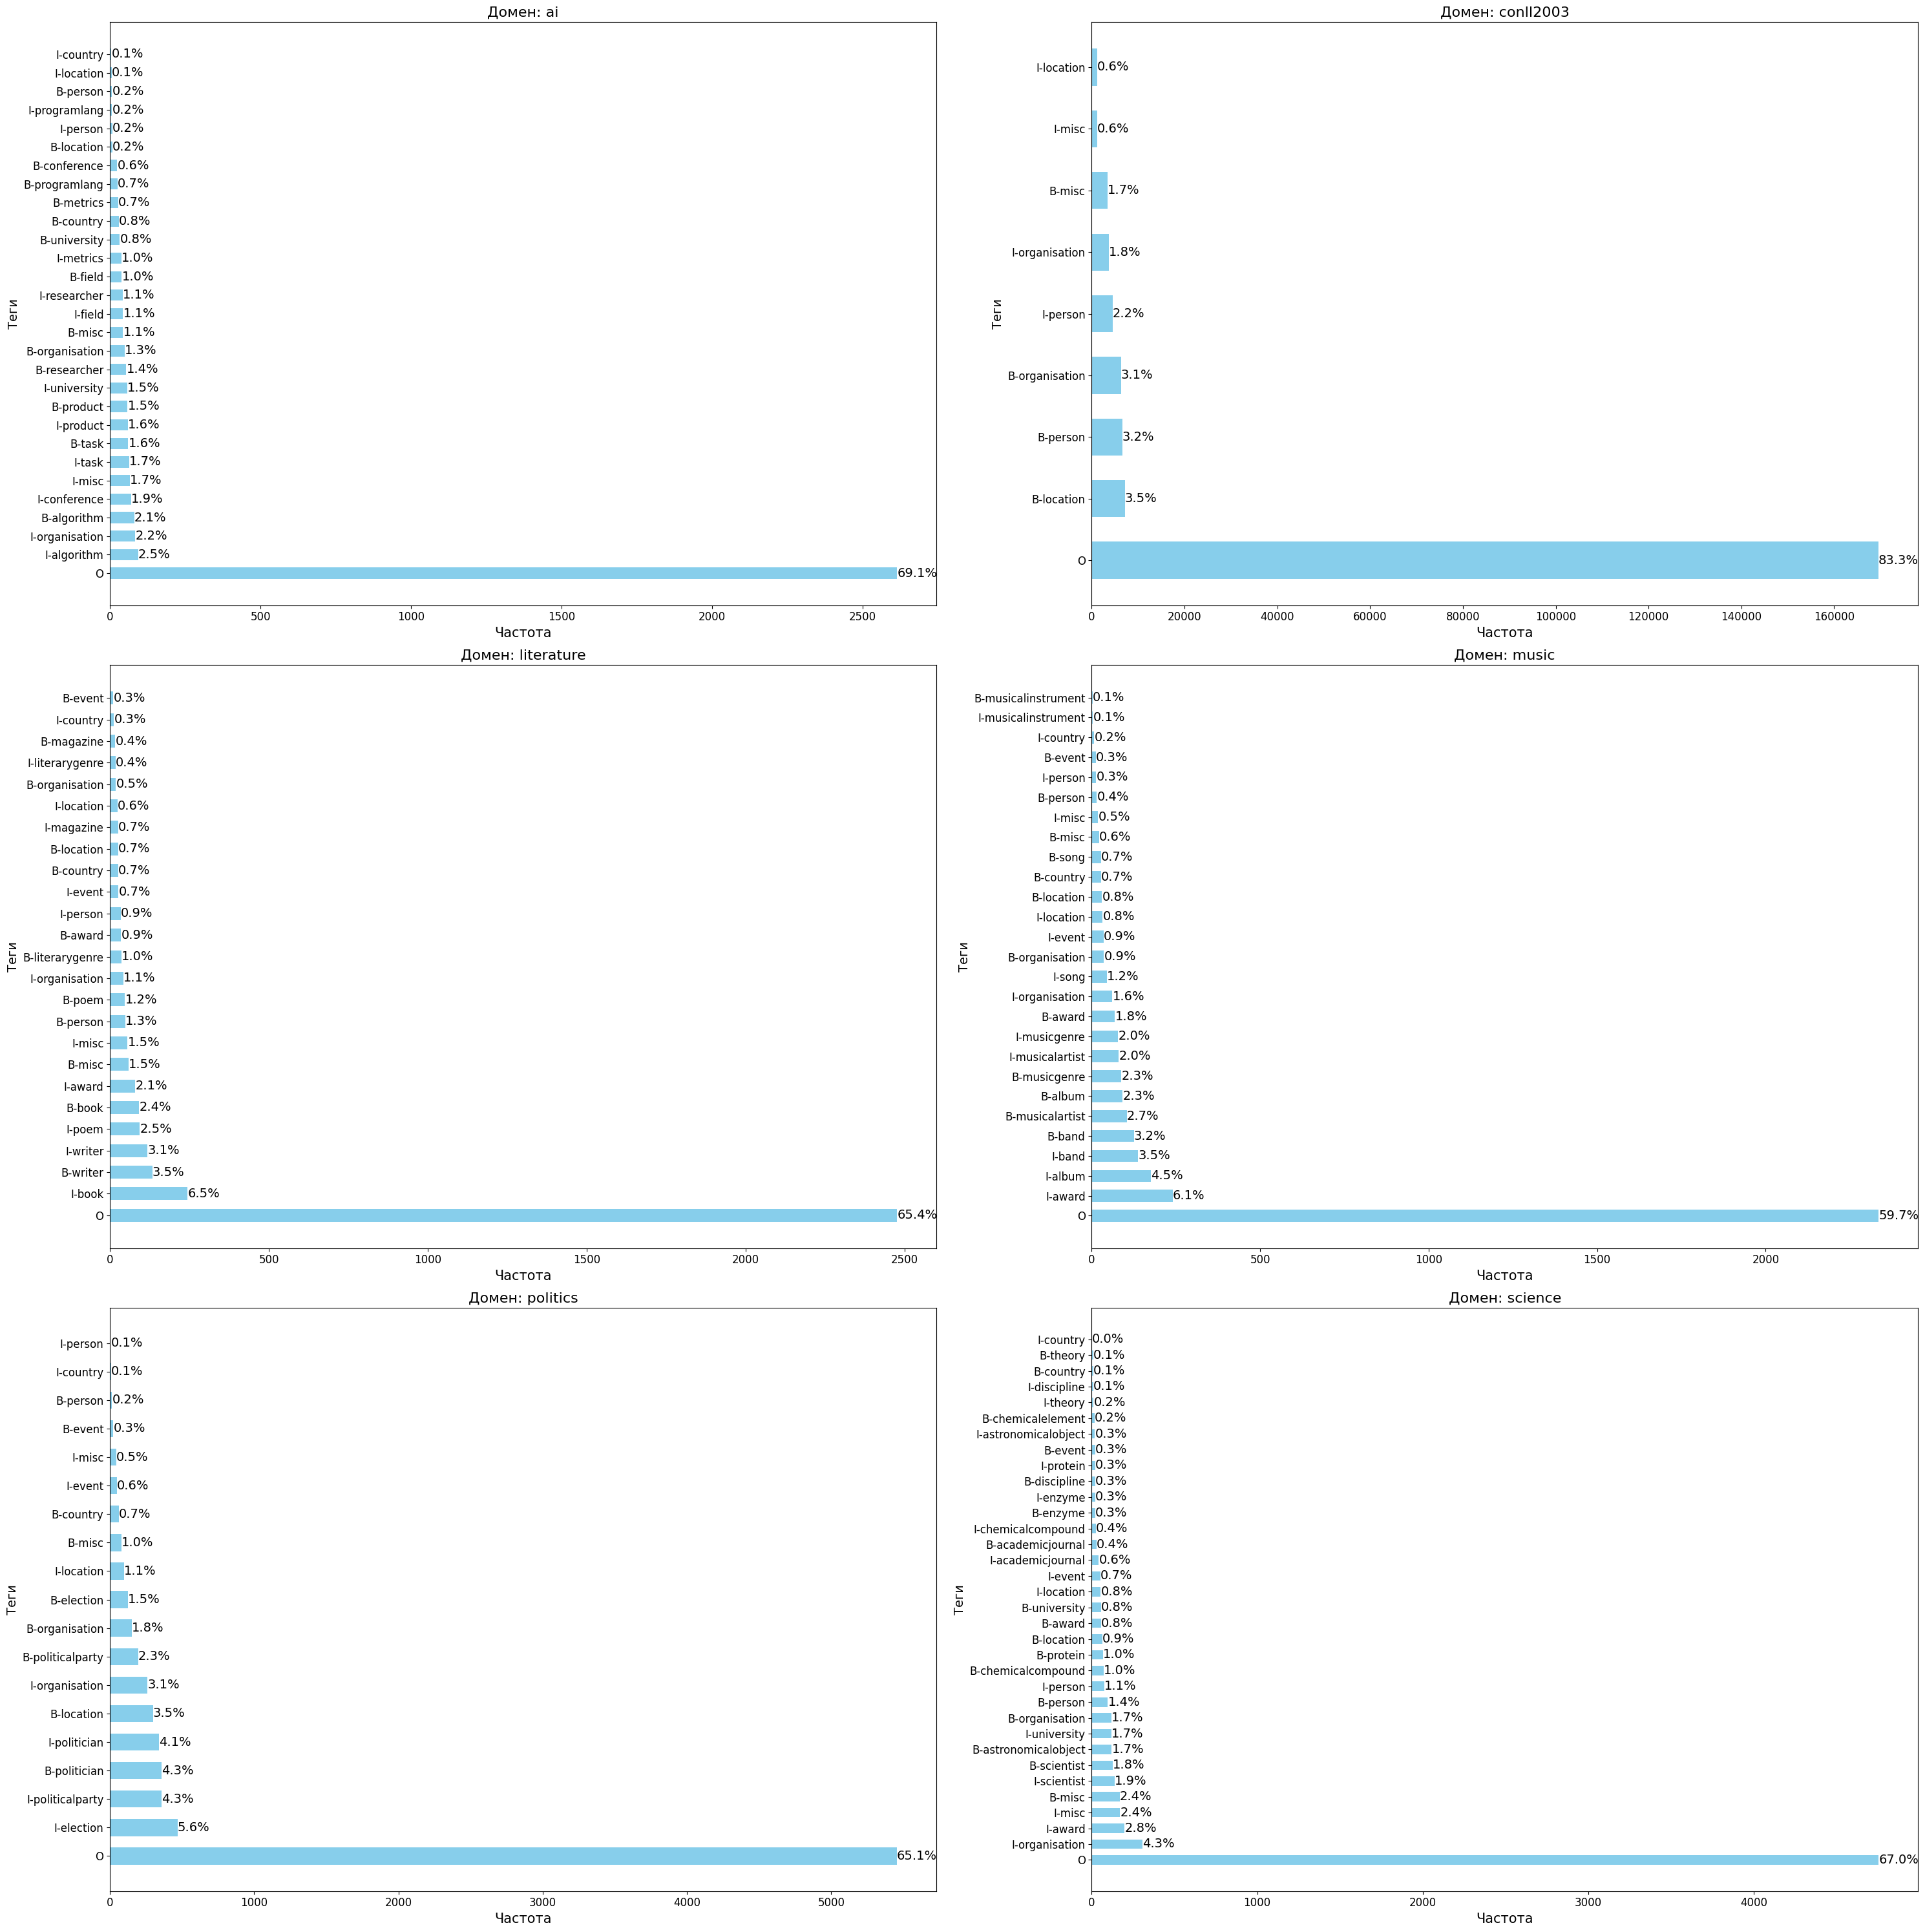

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

def get_domain_tag_counts(dataset, domain_name, id2tag):
    """
    Извлекает распределение тегов для заданного домена.
    """
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    all_tags = []
    for ex in domain_examples:
        all_tags.extend(ex["ner_tags"])
    counts = Counter(all_tags)
    named_counts = {id2tag[tag_id]: count for tag_id, count in counts.items()}
    return pd.DataFrame(list(named_counts.items()), columns=["tag_id", "count"])

def plot_tag_distribution_grid(dataset, id2tag, domains, cols=2):
    """
    Строит распределение тегов для каждого домена в виде сетки (решётки).
    """

    fig, axes = plt.subplots(3, 2, figsize=(cols * 10, 3 * 10))  # Увеличиваем общий размер графиков
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, domain in enumerate(domains):
        # Получаем распределение тегов для домена
        df_domain = get_domain_tag_counts(dataset["train"], domain, id2tag)

        # Подсчёт процентов
        total_count = df_domain["count"].sum()
        df_domain["percentage"] = df_domain["count"] / total_count * 100

        # Сортировка и настройка высоты
        df_domain = df_domain.sort_values(by="count", ascending=False).reset_index(drop=True)
        height = 0.6  # Увеличиваем высоту баров для улучшения видимости

        # Рисуем график на текущей оси
        ax = axes[i]
        ax.barh(df_domain["tag_id"], df_domain["count"], color="skyblue", height=height)
        ax.set_title(f"Домен: {domain}", fontsize=16)
        ax.set_xlabel("Частота", fontsize=15)
        ax.set_ylabel("Теги", fontsize=14)

        # Добавляем проценты на график
        for j, row in df_domain.iterrows():
            ax.text(row["count"] + 0.5, j, f"{row['percentage']:.1f}%", va='center', fontsize=14)

        # Уменьшаем шрифт осей
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=12)
    
    # Удаляем пустые оси, если доменов меньше, чем ячеек
    for j in range(len(domains), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Запуск функции для построения сетки
plot_tag_distribution_grid(dataset, id2tag, domains, cols=3)


Действительно, в рамках каждого отдельного домена распределение тегов не выглядит таким катастрофическим. Большая часть тегов рамках каждого домена представлена в большем количестве, чем 1%. Скорее всего в рамках обучения, датасет с самым низким качеством будет science, поскольку там наибольшее число тегов с частотой встречаемости меньше 1%, почти половина токенов - сильно малочисленны.

Поэтому наша гипотеза о том, что стоит учить каждую отдельную модель на каждый из доменов - обретает все больший смысл. Узнаем это на этапе тестирования)

### Распределение B vs I

Теперь посмотрим, как выглядят наши теги в зависимости от домена по длине.

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np

def get_entity_distribution_by_domain(dataset, domain_name, id2tag):
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    all_tags = []
    for ex in domain_examples:
        all_tags.extend(ex["ner_tags"])
    
    tag_counts = Counter(all_tags)
    tag_counts_named = {id2tag[tag_id]: count for tag_id, count in tag_counts.items()}

    entity_data = {}
    for tag_name, count in tag_counts_named.items():
        if tag_name == 'O':
            continue
        parts = tag_name.split('-', 1)
        if len(parts) < 2:
            continue
        prefix, entity_type = parts[0], parts[1]

        if entity_type not in entity_data:
            entity_data[entity_type] = {"B_count": 0, "I_count": 0}

        if prefix == 'B':
            entity_data[entity_type]["B_count"] += count
        elif prefix == 'I':
            entity_data[entity_type]["I_count"] += count

    df_entity = pd.DataFrame.from_dict(entity_data, orient='index').fillna(0)
    # Сортируем по сумме чтобы более популярные сущности шли первыми
    df_entity["total"] = df_entity["B_count"] + df_entity["I_count"]
    df_entity = df_entity.sort_values(by="total", ascending=False).drop(columns=["total"], errors="ignore")
    return df_entity

def plot_entity_distribution_side_by_side(df_entity, domain_name):
    # Преобразуем DataFrame так, чтобы удобно строить две колонки
    entity_types = df_entity.index.tolist()
    B_values = df_entity["B_count"].values
    I_values = df_entity["I_count"].values

    x = np.arange(len(entity_types))  # позиции по оси X
    width = 0.35  # ширина столбика

    fig, ax = plt.subplots(figsize=(10, max(3, len(entity_types)*0.3)))
    # Рисуем столбцы для B и I рядом друг с другом
    ax.bar(x - width/2, B_values, width, label='B-теги', color='skyblue')
    ax.bar(x + width/2, I_values, width, label='I-теги', color='lightgreen')

    ax.set_title(f"Распределение B- и I-тегов по типам сущностей для домена {domain_name} (train)")
    ax.set_xlabel("Тип сущности")
    ax.set_ylabel("Частота")
    ax.set_xticks(x)
    ax.set_xticklabels(entity_types, rotation=45, ha='right')  # Повернём надписи сущностей для компактности
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_entity_distribution_domain(train_dataset, domain):
    df_entity = get_entity_distribution_by_domain(train_dataset, domain, id2tag)
    if not df_entity.empty:
        plot_entity_distribution_side_by_side(df_entity, domain)
    else:
        print(f"Для домена {domain} нет сущностей или данных.")


Filter: 100%|██████████| 14741/14741 [00:00<00:00, 34082.04 examples/s]


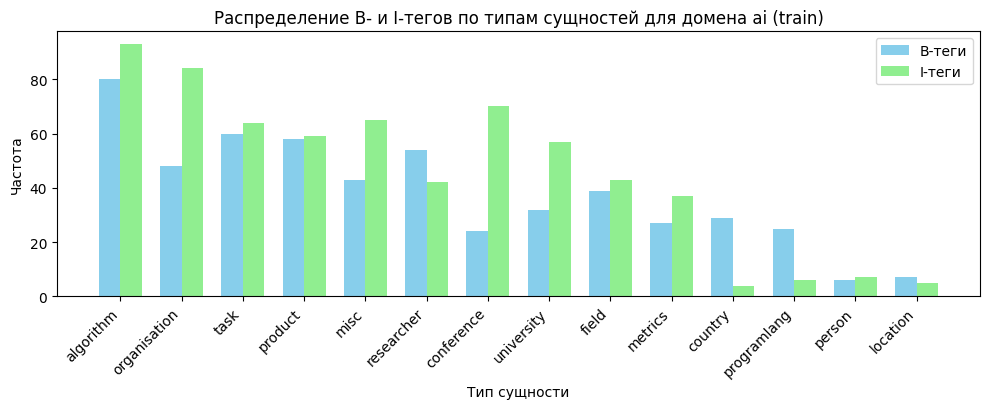

In [44]:
plot_entity_distribution_domain(dataset["train"], "ai")

Для ai домена мы видим, что такие теги как организация, конференция и университет, чаще имеют длину больше чем 1-2 слова. Оно и логично, потому что та же Высшая школа экономики состоит из 3 слов. Причем для этих слов разница почти в 1,5-2,5 раза, это значит, тег чаще всего состоит из 3-4 слов. Однако страна, как и язык программирования, чаще всего состоит именно из одного слова, потому что I-теги встречаются гораздо реже

Filter: 100%|██████████| 14741/14741 [00:00<00:00, 26392.03 examples/s]


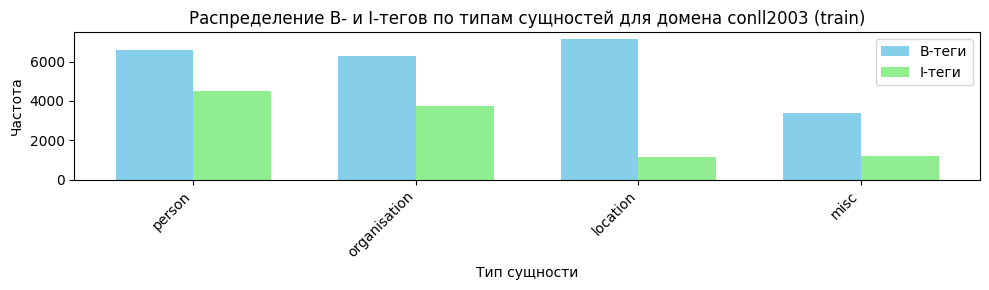

In [45]:
plot_entity_distribution_domain(dataset["train"], "conll2003")

Для домена conll2003 мы видим малую численность разных тегов и почти все они состоят из одного слова, встречаются теги, обозначающие человека (person), состоящие из двух, возможно 3ех слов.

Filter: 100%|██████████| 14741/14741 [00:00<00:00, 31743.95 examples/s]


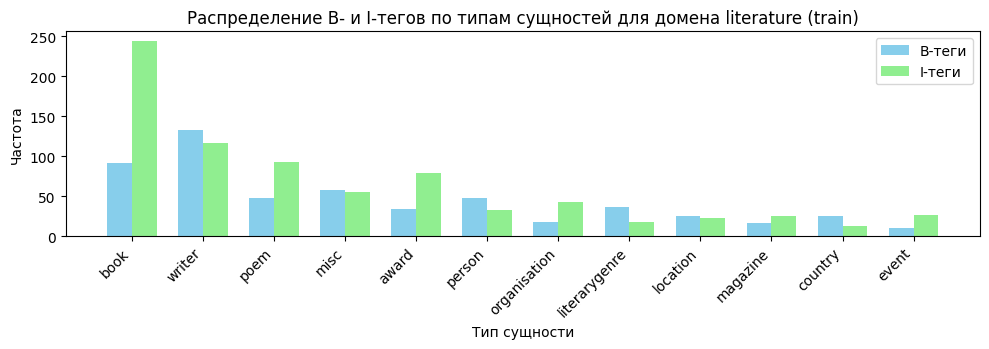

In [46]:
plot_entity_distribution_domain(dataset["train"], "literature")

В литературе мы видим большое количество слов именно в сущности обозначения книг. Вряд ли названия книг состоят из одного слова, обычно минимум два. Поэма, награда и организация тоже имеют больше 2-3 слов, обозначающих тег. Остальное придерживается 1-2 слов.

Filter: 100%|██████████| 14741/14741 [00:00<00:00, 30365.19 examples/s]


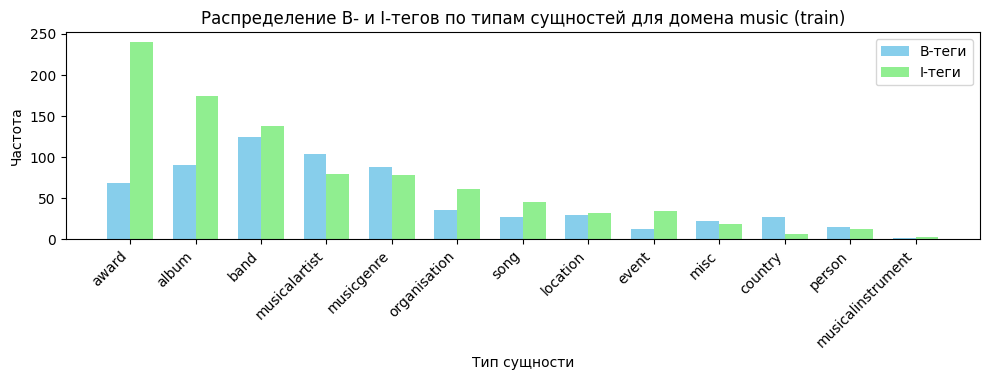

In [47]:
plot_entity_distribution_domain(dataset["train"], "music")

Описание сущностей музыки тоже имеет более длинные сущности, например, награда, альбом, организация содержат в себе скорее всего слова длины 3-4.

Filter: 100%|██████████| 14741/14741 [00:00<00:00, 33117.14 examples/s]


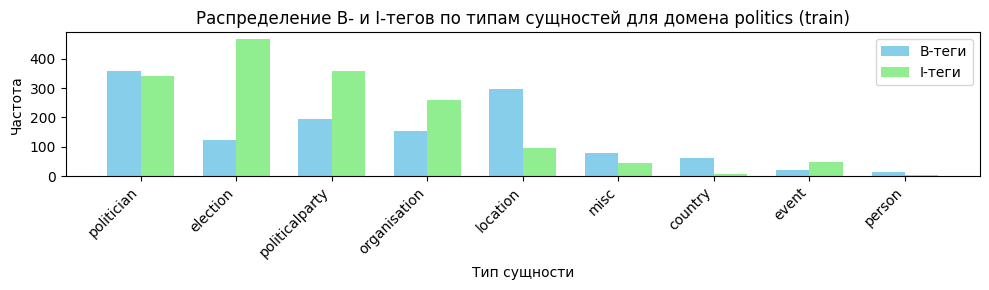

In [48]:
plot_entity_distribution_domain(dataset["train"], "politics")

В политике тег локация состоит из одного слова, в то время как сущность "выборы" состоит чаще из 3-4 слов.

Filter: 100%|██████████| 14741/14741 [00:00<00:00, 32600.13 examples/s]


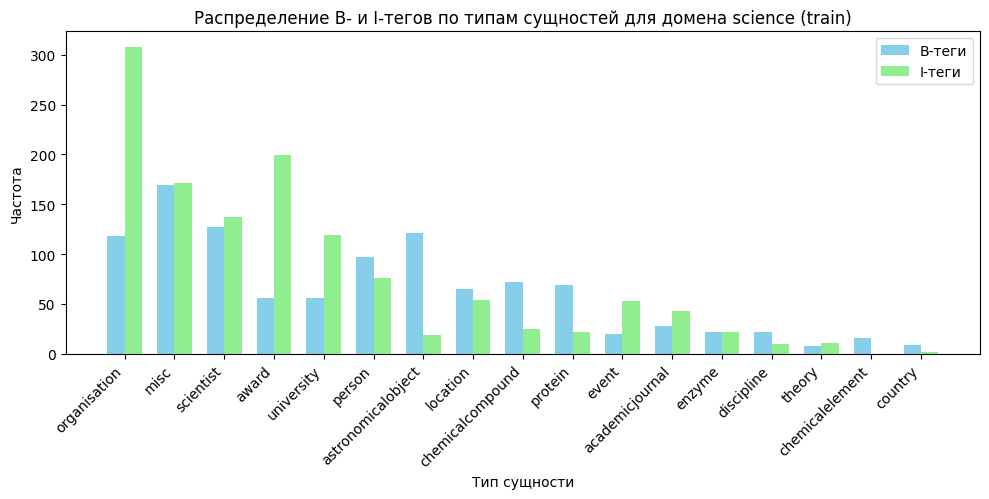

In [49]:
plot_entity_distribution_domain(dataset["train"], "science")

И наконец, наука, наименование организации, как и название университета или награды состоит больше чем из 2-3 слов, а вот астрономические обьекты и химическое соединение (chemicalcompound) состоят скорее всего из 1 слова.

## Анализ входных текстов

### Облака слов

Filter: 100%|██████████| 5959/5959 [00:00<00:00, 23976.21 examples/s]


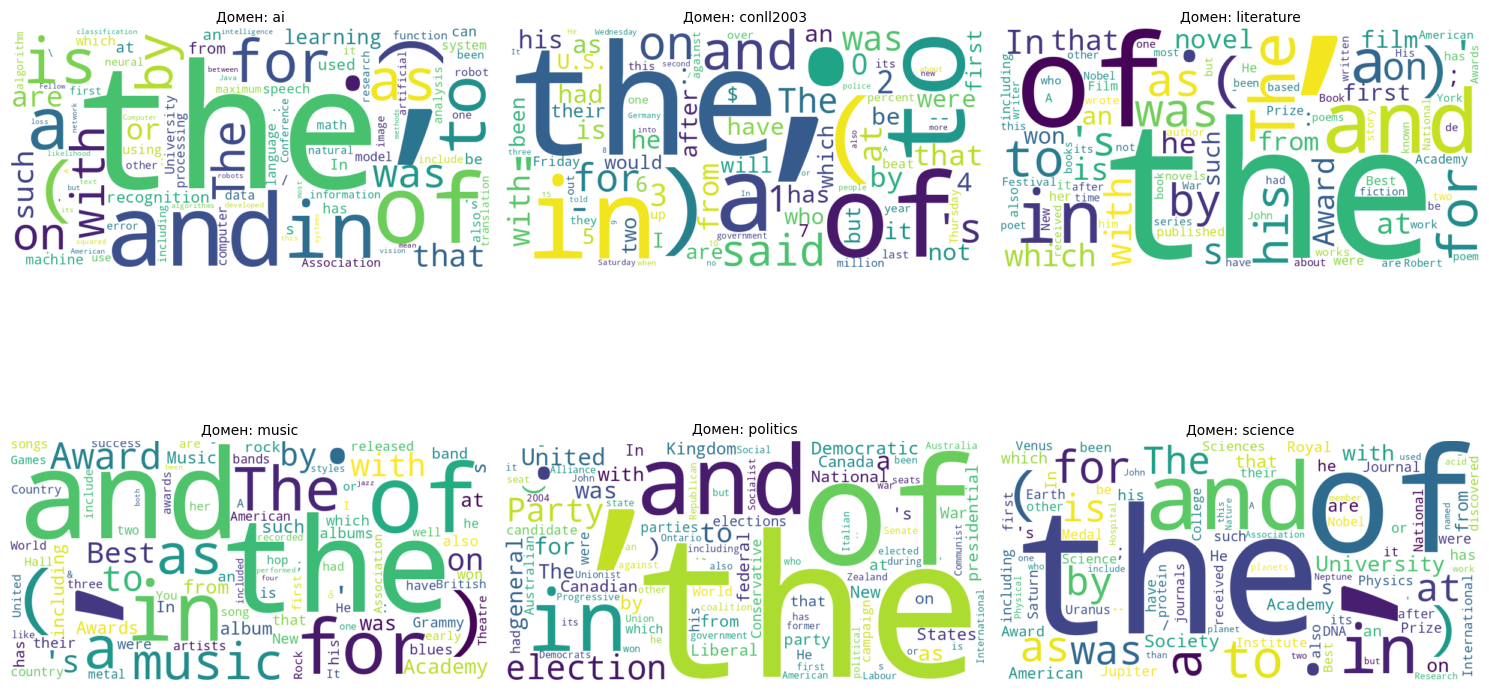

In [50]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import math

def get_domain_tokens(dataset, domain_name):
    """
    Извлекает все токены для заданного домена из датасета.
    """
    domain_examples = dataset.filter(lambda x: x["source"] == domain_name)
    all_tokens = []
    for ex in domain_examples:
        all_tokens.extend(ex["tokens"])
    return all_tokens

def plot_wordcloud_grid(dataset, max_words=100, cols=3):
    """
    Строит облака слов для каждого домена в виде сетки (решётки).
    """
    # Извлекаем уникальные домены
    domains = set()
    for split_name, split_dataset in dataset.items():
        domains.update(split_dataset["source"])
    domains = sorted(domains)  # Упорядочиваем домены

    # Определяем количество строк и столбцов для сетки
    rows = math.ceil(len(domains) / cols)

    # Создаём решётку
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, domain in enumerate(domains):
        # Собираем токены для домена из всех частей датасета
        tokens = []
        for split_name, split_dataset in dataset.items():
            tokens.extend(get_domain_tokens(split_dataset, domain))
        
        # Если токенов нет, пропускаем
        if not tokens:
            continue
        
        # Считаем частоты слов
        counter = Counter(tokens)
        # Генерируем облако слов
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              max_words=max_words, colormap='viridis').generate_from_frequencies(dict(counter))
        
        # Рисуем облако слов на текущей оси
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Домен: {domain}", fontsize=10)
        ax.axis("off")

    # Удаляем лишние оси (если графиков меньше, чем ячеек)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Настраиваем отступы и отображаем график
    plt.tight_layout()
    plt.show()

# Вызываем функцию для построения решётки облаков слов
plot_wordcloud_grid(dataset, max_words=100, cols=3)

Мы видим еще один момент, который может навредить нашему обучению, а именно - общие слова: the, and, in, that, with

И только потом, более мелкими мы видим слова, содержащие смысловой окрас именно для каждого домена: например, для науки это: DNA, Academy, University, Association. Для музыки это стили: rock, metal.

### Очистка на стоп слова

In [51]:
def clean_tokens(example):
    original_tokens = example["tokens"]
    original_tags = example["ner_tags"]
    
    cleaned = []
    cleaned_tags = []
    removed_tokens = []  # Храним удаленные токены и их теги

    
    for token, tag_id in zip(original_tokens, original_tags):
        tag_name = id2tag[tag_id]

        # Проверяем стоп-слово
        if token.lower() in stop_words:
            # Стоп-слово: добавляем в список удаленных только если тег важный
            if tag_name != "O":
                removed_tokens.append({"token": token, "tag": tag_name})
            continue
        # Если не стоп-слово, оставляем
        cleaned.append(token)
        cleaned_tags.append(tag_id)
    
    # Возвращаем очищенные токены и удаленные важные токены
    return {
        "cleaned_tokens": cleaned,
        "removed_tokens": removed_tokens,
        "cleaned_tags" : cleaned_tags
    }


# Подсчёт статистики: смотрим на все удаленные токены с важными тегами
def analyze_removed_tokens(dataset, dataset_name):
    all_removed = []
    for removed in dataset["removed_tokens"]:
        all_removed.extend(removed)
    
    # Подсчитываем наиболее часто удаляемые важные токены
    if all_removed:
        df_removed = pd.DataFrame(all_removed)
        removed_stats = df_removed.value_counts().reset_index(name="count")
        removed_stats.columns = ["token", "tag", "count"]
        print(f"\nТоп удаленных токенов с важными тегами ({dataset_name}):")
        print(removed_stats.head(10))
    else:
        print(f"\nВ {dataset_name} не было удалено токенов с важными тегами.")


for split in dataset.keys():
    dataset[split] = dataset[split].map(clean_tokens)
    analyze_removed_tokens(dataset[split], split)

Map: 100%|██████████| 14741/14741 [00:01<00:00, 11885.19 examples/s]



Топ удаленных токенов с важными тегами (train):
              token  tag  count
0    I-organisation   of    186
1    I-organisation  and     72
2           I-award  for     45
3  I-politicalparty   of     45
4      I-university   of     40
5            I-misc   of     36
6    I-organisation  for     30
7            I-book   of     29
8           I-award   of     26
9            B-book  The     25


Map: 100%|██████████| 5371/5371 [00:00<00:00, 8254.44 examples/s] 



Топ удаленных токенов с важными тегами (val):
              token  tag  count
0    I-organisation   of    257
1  I-politicalparty   of    225
2           I-award  for    142
3            B-book  The     97
4            I-book   of     79
5    I-organisation  for     79
6      I-university   of     74
7    I-organisation  and     62
8            I-misc   of     54
9            I-book  the     53


Map: 100%|██████████| 5959/5959 [00:00<00:00, 11442.08 examples/s]


Топ удаленных токенов с важными тегами (test):
              token  tag  count
0    I-organisation   of    268
1  I-politicalparty   of    188
2           I-award  for    148
3            B-book  The    137
4            I-book   of     90
5      I-university   of     80
6           I-award   of     73
7    I-organisation  for     72
8    I-organisation  and     70
9            B-band  The     59


In [52]:
dataset["train"]

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'source', 'tags_named', 'cleaned_tokens', 'removed_tokens', 'cleaned_tags'],
    num_rows: 14741
})

То есть если мы удаляем стоп слова есть вероятность зацепить внутренние связки между словами, которые определяются тегом I-<entry> и так же удаляются предлоги, обозначающие начало связки, как например у B-band, скорее всего название начинается как-нибудь "The ....".

Мы можем продолжить работу с очищенным словарем, но тогда надо тогда понять, как заменять эти пробелы на этапе инференса на тесте, если мы их удаляем.

Мы решили упростить себе задачу и дальше экспериментировать только над частью AI, потому что датасеты зашумлены, сильно отличаются между собой и скорее всего будут только мешать качеству распознавания в совокупности. А так как AI домен и так достаточно большой - мы решили сосредоточиться на нем.

### Распредение длины предложений

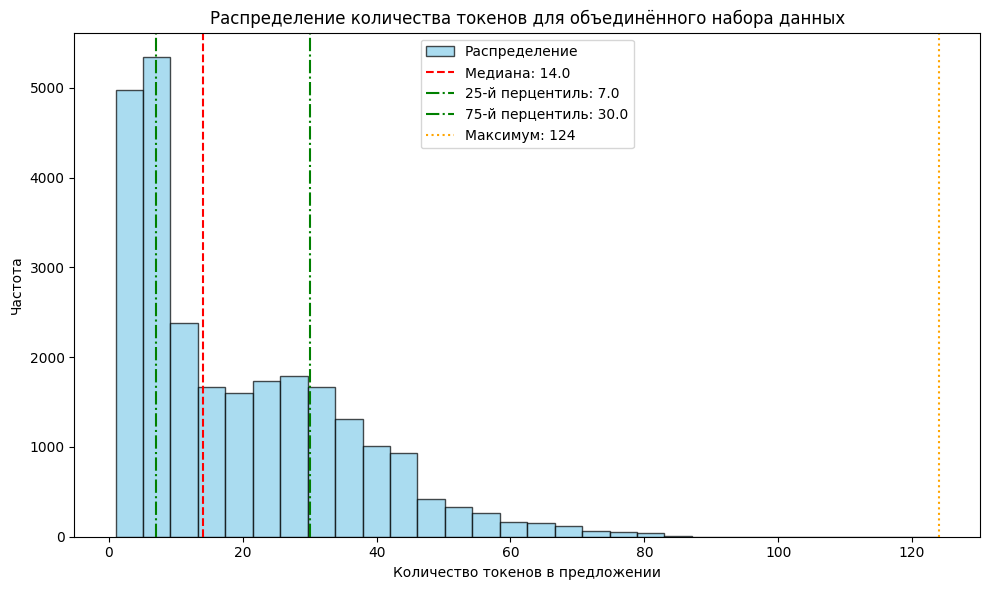

In [53]:
def plot_combined_token_distribution(dataset, percentiles=[25, 75]):
    """
    Рассчитывает распределение количества токенов в предложениях
    для объединённого набора данных и строит гистограмму с медианой,
    перцентилями и максимальным значением.
    """
    # Объединяем все токены из train, val, test в один список
    lengths = []
    for split_name, split_dataset in dataset.items():
        lengths.extend([len(tokens) for tokens in split_dataset["tokens"]])
    
    # Рассчитываем медиану, перцентили и максимальное значение
    median = np.median(lengths)
    perc_values = np.percentile(lengths, percentiles)
    max_value = np.max(lengths)

    # Построим гистограмму
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=30, color="skyblue", edgecolor="black", alpha=0.7, label="Распределение")
    
    # Добавляем медиану
    plt.axvline(median, color="red", linestyle="--", label=f"Медиана: {median}")
    
    # Добавляем перцентили
    for p, val in zip(percentiles, perc_values):
        plt.axvline(val, color="green", linestyle="-.", label=f"{p}-й перцентиль: {val}")
    
    # Добавляем максимальное значение
    plt.axvline(max_value, color="orange", linestyle=":", label=f"Максимум: {max_value}")
    
    # Настраиваем график
    plt.title("Распределение количества токенов для объединённого набора данных")
    plt.xlabel("Количество токенов в предложении")
    plt.ylabel("Частота")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Вызываем функцию для объединённого набора данных
plot_combined_token_distribution(dataset, percentiles=[25, 75])

Таким образом, мы видим, что у нас есть совсем мало, но предложений большой длины. Давайте посмотрим в разрезе доменов:

Filter: 100%|██████████| 5959/5959 [00:00<00:00, 16174.39 examples/s]


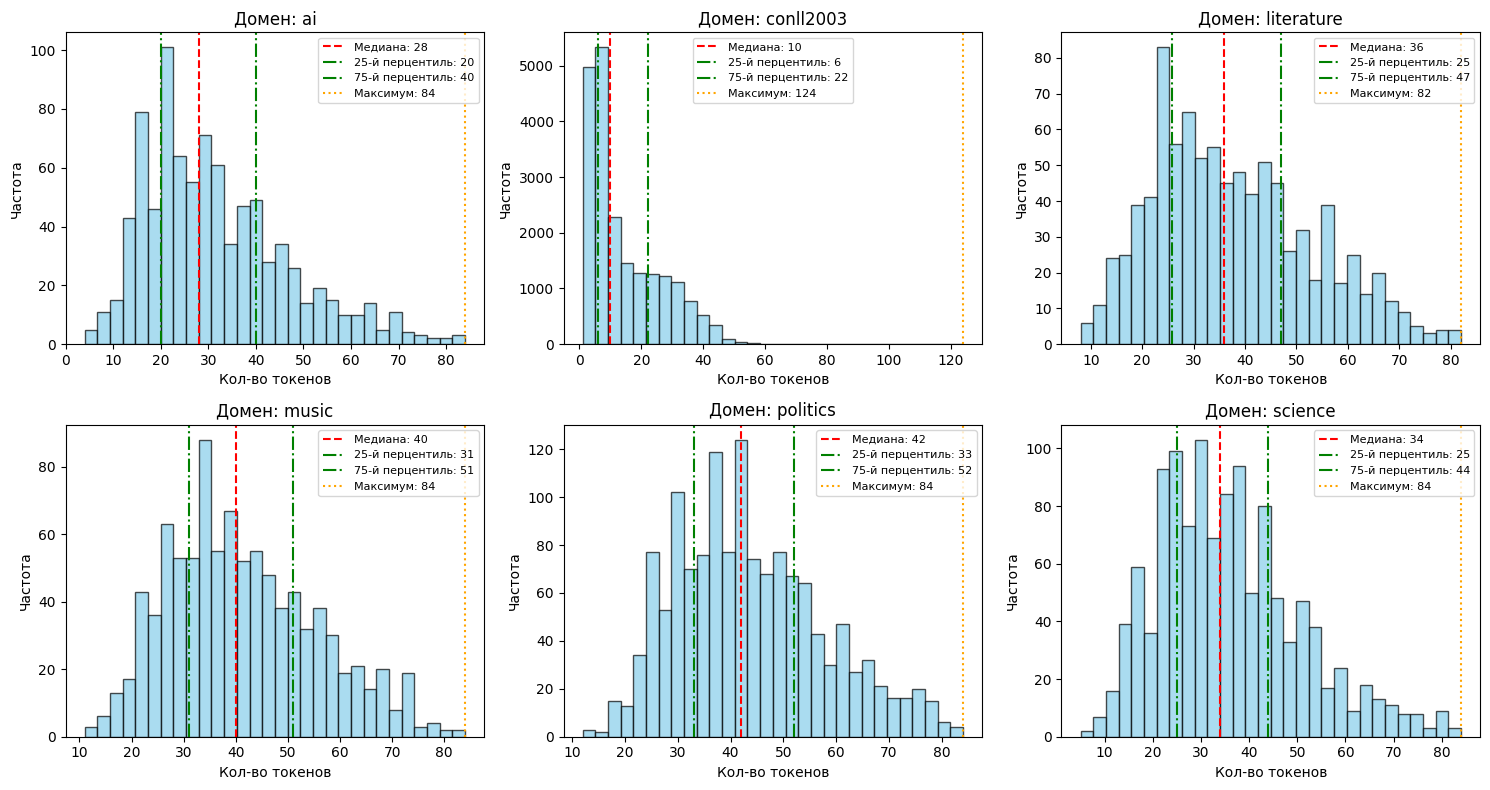

In [54]:
def plot_token_distribution_grid(dataset, percentiles=[25, 75], cols=3):
    """
    Строит гистограммы распределения количества токенов для каждого домена
    в виде сетки (решётки).
    """
    # Извлекаем уникальные домены
    domains = set()
    for split_name, split_dataset in dataset.items():
        domains.update(split_dataset["source"])
    domains = sorted(domains)  # Упорядочиваем домены

    # Определяем количество строк и столбцов для графиков
    rows = math.ceil(len(domains) / cols)
    
    # Создаём решётку
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Преобразуем в одномерный массив для удобства

    for i, domain in enumerate(domains):
        # Объединяем длины предложений для текущего домена из всех частей (train, val, test)
        lengths = []
        for split_name, split_dataset in dataset.items():
            domain_examples = split_dataset.filter(lambda x: x["source"] == domain)
            lengths.extend([len(tokens) for tokens in domain_examples["tokens"]])
        
        # Рассчитываем статистики
        median = np.median(lengths)
        perc_values = np.percentile(lengths, percentiles)
        max_value = np.max(lengths)
        
        # Строим гистограмму на текущей оси
        ax = axes[i]
        ax.hist(lengths, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
        ax.axvline(median, color="red", linestyle="--", label=f"Медиана: {int(median)}")
        for p, val in zip(percentiles, perc_values):
            ax.axvline(val, color="green", linestyle="-.", label=f"{p}-й перцентиль: {int(val)}")
        ax.axvline(max_value, color="orange", linestyle=":", label=f"Максимум: {int(max_value)}")
        
        # Подписываем график
        ax.set_title(f"Домен: {domain}")
        ax.set_xlabel("Кол-во токенов")
        ax.set_ylabel("Частота")
        ax.legend(fontsize=8)
    
    # Удаляем пустые оси (если графиков меньше, чем ячеек)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Настраиваем отступы и выводим график
    plt.tight_layout()
    plt.show()

# Вызываем функцию для построения решётки
plot_token_distribution_grid(dataset, percentiles=[25, 75], cols=3)


Интересный момент, что для всех доменов, кроме сonll2003, мы видим чуть близкое к нормальному распределению и длина предложений у нас лежит в от 10 до 85 слов (токенов). А сonll2003 вообще не распределен нормально и половина (по медиане) текстов содержат меньше 10 слов в предложении. Однако другая половина сильно растянулась, 25% текстов имеют длину от 22 слов до 124.

Вероятнее всего, при таком раскладе действительно стоит отдельную модель под каждый домен, нежели чем одну общую. Или попытаться например, обучить на 5 доменах одну и на 1 домене (сonll2003) другую. Эти соображения аргументированы тем, что модель на домене сonll2003 скорее всего будет больше смотреть и лучше выявлять сущности вначале, а на более длинных текстах будет больший процент ошибки - их просто мало. В то время как на других доменах модель будет акцентироваться на текстах до 80 токенов и при большем количестве - вероятнее всего будет ошибаться.

### Пересечение вокабуляра

Filter: 100%|██████████| 5959/5959 [00:00<00:00, 15968.09 examples/s]


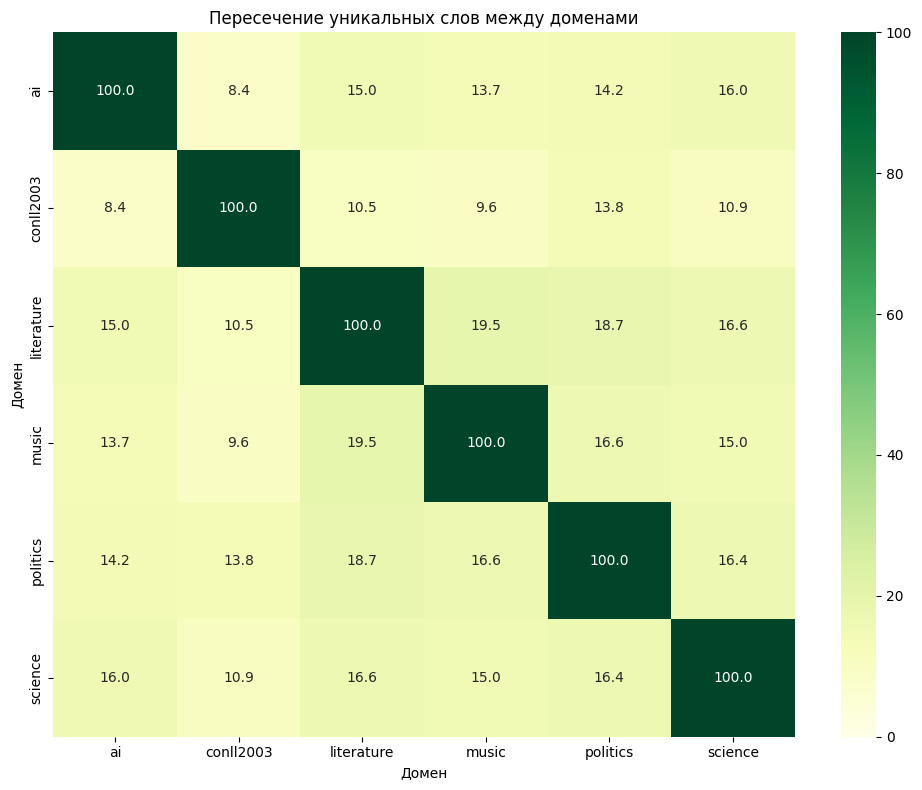

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_unique_tokens_by_domain(dataset, domains):
    """
    Собирает уникальные слова для каждого домена.
    """
    domain_tokens = {}
    for domain in domains:
        all_tokens = []
        for split_name, split_dataset in dataset.items():
            domain_examples = split_dataset.filter(lambda x: x["source"] == domain)
            for ex in domain_examples:
                all_tokens.extend(ex["tokens"])
        domain_tokens[domain] = set(all_tokens)
    return domain_tokens

def compute_token_overlap_matrix(domain_tokens):
    """
    Рассчитывает матрицу пересечения уникальных слов между доменами.
    """
    domains = list(domain_tokens.keys())
    matrix = pd.DataFrame(index=domains, columns=domains, data=0.0)
    
    for d1 in domains:
        for d2 in domains:
            set1 = domain_tokens[d1]
            set2 = domain_tokens[d2]
            intersection = set1.intersection(set2)
            union = set1.union(set2)
            overlap = (len(intersection) / len(union)) * 100 if len(union) > 0 else 0.0
            matrix.loc[d1, d2] = overlap
    
    return matrix

def plot_overlap_heatmap(matrix, title):
    """
    Визуализирует матрицу пересечений в виде тепловой карты.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".1f", cmap="YlGn", vmin=0, vmax=100)
    plt.title(title)
    plt.xlabel("Домен")
    plt.ylabel("Домен")
    plt.tight_layout()
    plt.show()

# Получаем уникальные слова для каждого домена
domain_tokens = get_unique_tokens_by_domain(dataset, domains)

# Рассчитываем матрицу пересечения уникальных слов
token_overlap_matrix = compute_token_overlap_matrix(domain_tokens)

# Визуализируем пересечение
plot_overlap_heatmap(token_overlap_matrix, "Пересечение уникальных слов между доменами")


Интересно, что в контексте пересечения вокабуляра - пересечение текстов больше между квадратом -литература, музыка, политика и наука, а меньше всего пересечения именно у conll2003 домена.

# Rule-based method

## Выбор фреймворка для задачи NER

Для решения задачи распознавания именованных сущностей (NER) на английсклом языке мы выбрали **SpaCy**. 

SpaCy имеет мощную поддержку английского языка и предоставляет готовые модели для NER, обученные на больших наборах данных.

## Первое решение

In [508]:
rb_model = spacy.load('en_core_web_md')

ner = rb_model.get_pipe("ner") # NER компонент из nlp pipeline

print("Доступные сущности (теги):")
for label in ner.labels:
    print(f"* {label} — {spacy.explain(label)}")

Доступные сущности (теги):
* CARDINAL — Numerals that do not fall under another type
* DATE — Absolute or relative dates or periods
* EVENT — Named hurricanes, battles, wars, sports events, etc.
* FAC — Buildings, airports, highways, bridges, etc.
* GPE — Countries, cities, states
* LANGUAGE — Any named language
* LAW — Named documents made into laws.
* LOC — Non-GPE locations, mountain ranges, bodies of water
* MONEY — Monetary values, including unit
* NORP — Nationalities or religious or political groups
* ORDINAL — "first", "second", etc.
* ORG — Companies, agencies, institutions, etc.
* PERCENT — Percentage, including "%"
* PERSON — People, including fictional
* PRODUCT — Objects, vehicles, foods, etc. (not services)
* QUANTITY — Measurements, as of weight or distance
* TIME — Times smaller than a day
* WORK_OF_ART — Titles of books, songs, etc.


Ключевая проблема сразу: у нас сильно больше сущностей, прямо очень, мы можем попытаться уйти от такого количества класса, что конечно решение, но немного такое себе. Но давайте на текущем этапе попробуем так.

In [509]:
custom_to_spacy = {
    # PERSON-related entities
    "B-person": "PERSON",
    "I-person": "PERSON",
    "B-writer": "PERSON",
    "I-writer": "PERSON",
    "B-researcher": "PERSON",
    "I-researcher": "PERSON",
    "B-politician": "PERSON",
    "I-politician": "PERSON",
    "B-scientist": "PERSON",
    "I-scientist": "PERSON",

    # ORG-related entities
    "B-organisation": "ORG",
    "I-organisation": "ORG",
    "B-university": "ORG",
    "I-university": "ORG",
    "B-band": "ORG",
    "I-band": "ORG",
    "B-politicalparty": "ORG",
    "I-politicalparty": "ORG",

    # GPE-related entities (countries)
    "B-country": "GPE",
    "I-country": "GPE",

    # LOC-related entities
    "B-location": "LOC",
    "I-location": "LOC",
    "B-astronomicalobject": "LOC",
    "I-astronomicalobject": "LOC",

    # WORK_OF_ART-related entities
    "B-book": "WORK_OF_ART",
    "I-book": "WORK_OF_ART",
    "B-poem": "WORK_OF_ART",
    "I-poem": "WORK_OF_ART",
    "B-song": "WORK_OF_ART",
    "I-song": "WORK_OF_ART",
    "B-album": "WORK_OF_ART",
    "I-album": "WORK_OF_ART",
    "B-literarygenre": "WORK_OF_ART",
    "I-literarygenre": "WORK_OF_ART",

    # PRODUCT-related entities
    "B-product": "PRODUCT",
    "I-product": "PRODUCT",
    "B-musicalinstrument": "PRODUCT",
    "I-musicalinstrument": "PRODUCT",
    "B-algorithm": "PRODUCT",
    "I-algorithm": "PRODUCT",
    "B-theory": "PRODUCT",
    "I-theory": "PRODUCT",

    # EVENT-related entities
    "B-event": "EVENT",
    "I-event": "EVENT",
    "B-conference": "EVENT",
    "I-conference": "EVENT",
    "B-election": "EVENT",
    "I-election": "EVENT",
    "B-award": "EVENT",
    "I-award": "EVENT",
    
    "B-discipline": "PRODUCT",
    "I-discipline": "PRODUCT",

    # LANGUAGE-related entities
    "B-programlang": "LANGUAGE",
    "I-programlang": "LANGUAGE",

    # LAW-related entities
    "B-misc": "LAW",
    "I-misc": "LAW",

    "B-metrics": "QUANTITY",
    "I-metrics": "QUANTITY",

    # ORDINAL-related entities
    "B-task": "PRODUCT",
    "I-task": "PRODUCT",

    # QUANTITY-related entities
    "B-field": "QUANTITY",
    "I-field": "QUANTITY",

    # CHEMICAL-related entities
    "B-chemicalcompound": "PRODUCT",
    "I-chemicalcompound": "PRODUCT",
    "B-chemicalelement": "PRODUCT",
    "I-chemicalelement": "PRODUCT",
    "B-enzyme": "PRODUCT",
    "I-enzyme": "PRODUCT",
    "B-protein": "PRODUCT",
    "I-protein": "PRODUCT",

    # Default
    "O": "O"
}

In [510]:
def map_custom_to_spacy(tag, custom_to_spacy = None):
    """
    Преобразует кастомный тег в формат SpaCy.

    Args:
    - tag (str): Кастомный тег (например, B-tag, I-tag).
    - custom_to_spacy (dict): Словарь для маппинга кастомных тегов в SpaCy.

    Returns:
    - str: Тег в формате SpaCy (без B- или I-, в верхнем регистре).
    """
    if custom_to_spacy:
        return custom_to_spacy.get(tag, "O")
    
    if tag == "O":
        return tag
    tag = tag.split("-", 1)[-1]  # Убираем префиксы B- или I-
    return tag.upper()  # Преобразуем к верхнему регистру


In [513]:
def evaluate_ner_per_domain(dataset, nlp, matcher = None, custom_to_spacy = None, domains = ["ai"]):
    """
    Рассчитывает метрики и возвращает разметку для каждого домена.
    """
    domain_results = {}
    all_annotations = []

    for domain in domains:
        print(f"Обрабатываем домен: {domain}")

        # Фильтруем примеры по домену
        domain_examples = dataset.filter(lambda x: x["source"] == domain)

        all_y_true = []
        all_y_pred = []
        annotations = []

        for example in domain_examples:
            tokens = example["tokens"]
            gold_tags = example["tags_named"]  # Золотые теги в кастомном формате

            # Преобразуем золотые теги в формат SpaCy и переводим в upper case
            transformed_gold_tags = [map_custom_to_spacy(tag, custom_to_spacy) for tag in gold_tags]

            # Преобразуем токены в текст
            text = " ".join(tokens)

            # Применение матчинга
            doc = nlp(text)
            predicted_tags = ["O"] * len(tokens)  # Инициализация предсказанных тегов

            if matcher:
                matches = matcher(doc)
                for match_id, start, end in matches:
                    label = nlp.vocab.strings[match_id]
                    for i in range(start, end):
                        if i < len(tokens):
                            predicted_tags[i] = label.upper()
            else:
                for ent in doc.ents:
                # Определяем начало и конец сущностей
                    start_idx = len(" ".join(tokens[:ent.start]).split())
                    end_idx = len(" ".join(tokens[:ent.end]).split())

                    # Применяем тег, предсказанный SpaCy
                    for i in range(start_idx, min(end_idx, len(tokens))):
                        predicted_tags[i] = ent.label_

            # Проверяем длины и сохраняем теги
            if len(transformed_gold_tags) != len(predicted_tags):
                print(f"Ошибка! Несоответствие длины для текста: {text}")
                print(f"gold_tags: {len(transformed_gold_tags)}, predicted_tags: {len(predicted_tags)}")
                continue

            # Сохраняем результаты
            all_y_true.extend(transformed_gold_tags)
            all_y_pred.extend(predicted_tags)

            annotations.append({
                "domain": domain,  # Добавляем информацию о домене
                "tokens": tokens,
                "gold_tags": transformed_gold_tags,
                "predicted_tags": predicted_tags
            })

        # Проверяем общую длину списков
        if len(all_y_true) != len(all_y_pred):
            raise ValueError(f"Несоответствие длины all_y_true ({len(all_y_true)}) и all_y_pred ({len(all_y_pred)}) для домена {domain}")

        # Рассчитываем метрики
        precision, recall, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average="macro")
        accuracy = accuracy_score(all_y_true, all_y_pred)

        # Сохраняем результаты метрик для домена
        domain_results[domain] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Accuracy": accuracy
        }

        # Добавляем аннотации для домена
        all_annotations.extend(annotations)

    # Преобразуем результаты метрик в DataFrame
    metrics_df = pd.DataFrame.from_dict(domain_results, orient="index").reset_index().rename(columns={"index": "Domain"})

    return metrics_df, all_annotations

In [514]:
# Пример применения к данным (val)
domains = ["ai", "conll2003", "literature", "music", "politics", "science"]
metrics_df, annotations = evaluate_ner_per_domain(dataset["test"],nlp = rb_model, custom_to_spacy = custom_to_spacy, domains = domains)

Обрабатываем домен: ai
Обрабатываем домен: conll2003
Обрабатываем домен: literature
Обрабатываем домен: music
Обрабатываем домен: politics
Обрабатываем домен: science


## Метрики

### Общие

In [515]:
metrics_df

Domain  Precision    Recall  F1-score  Accuracy
0          ai   0.213980  0.189376  0.154434  0.720730
1   conll2003   0.143578  0.100970  0.107137  0.738645
2  literature   0.188671  0.174803  0.153325  0.697469
3       music   0.148491  0.163777  0.114255  0.626728
4    politics   0.204932  0.156034  0.145618  0.692115
5     science   0.207219  0.159419  0.137146  0.700056

Важно: это у нас Macro метрики, то есть мы смотрим в основном на f1 score, precision и recall из-за сильного дисбаланса датасетов, где 70-80 процентов данных - это O тего.

Итак, по текущим метрикам: Мы получили средния значения метрик по всем доменам, что мы видим: в целом, мы справляемся со всеми метриками на уровне 10-20%, а точность близка к 70 процентам. Есть большая вероятность, что это так, просто потому что большая часть разметок это O теги, а это для нас будет не совсем релевантно. Поэтому посмотрим другие типы графиков:

### Confusion matrics by domain and tag

In [65]:
def plot_confusion_matrices_spacy_with_domains(annotations, domains):
    """
    Строит решетку матриц конфузий по каждому домену для тегов в формате SpaCy.
    """
    # Получаем уникальные теги из аннотаций (в формате SpaCy)
    unique_tags = sorted({tag for ann in annotations for tag in ann["gold_tags"] + ann["predicted_tags"] if tag != "O"})
    
    if not unique_tags:
        print("Ошибка: уникальные теги отсутствуют! Проверьте формат данных.")
        return

    print(f"Уникальные теги: {unique_tags}")

    # Определяем размеры решетки
    cols = 1  # Количество колонок
    rows = (len(domains) + cols - 1) // cols  # Количество строк
    # print(rows)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 5))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]  # Преобразуем в 1D массив для удобства работы

    for idx, domain in enumerate(domains):
        # Отбираем аннотации для текущего домена
        domain_annotations = [ann for ann in annotations if ann["domain"] == domain]

        # Проверяем, есть ли аннотации для домена
        if not domain_annotations:
            print(f"Данные для домена '{domain}' отсутствуют.")
            axes[idx].axis('off')  # Отключаем пустую ось
            continue

        # Составляем списки золотых и предсказанных тегов
        y_true = []
        y_pred = []
        for ann in domain_annotations:
            y_true.extend(ann["gold_tags"])
            y_pred.extend(ann["predicted_tags"])

        # Рассчитываем матрицу конфузий
        cm = confusion_matrix(y_true, y_pred, labels=unique_tags)

        # Проверяем, не пустая ли матрица
        if cm.sum() == 0:
            print(f"Предупреждение: матрица конфузий для домена '{domain}' пуста.")
            axes[idx].axis('off')  # Отключаем пустую ось
            continue

        # Нормализуем матрицу по строкам (опционально)
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        # Рисуем тепловую карту
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=unique_tags, yticklabels=unique_tags, ax=axes[idx])
        axes[idx].set_title(f"Confusion Matrix: {domain}")
        axes[idx].set_xlabel("Predicted Tags")
        axes[idx].set_ylabel("True Tags")

    # Удаляем пустые оси, если доменов меньше, чем ячеек
    for idx in range(len(domains), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

Уникальные теги: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


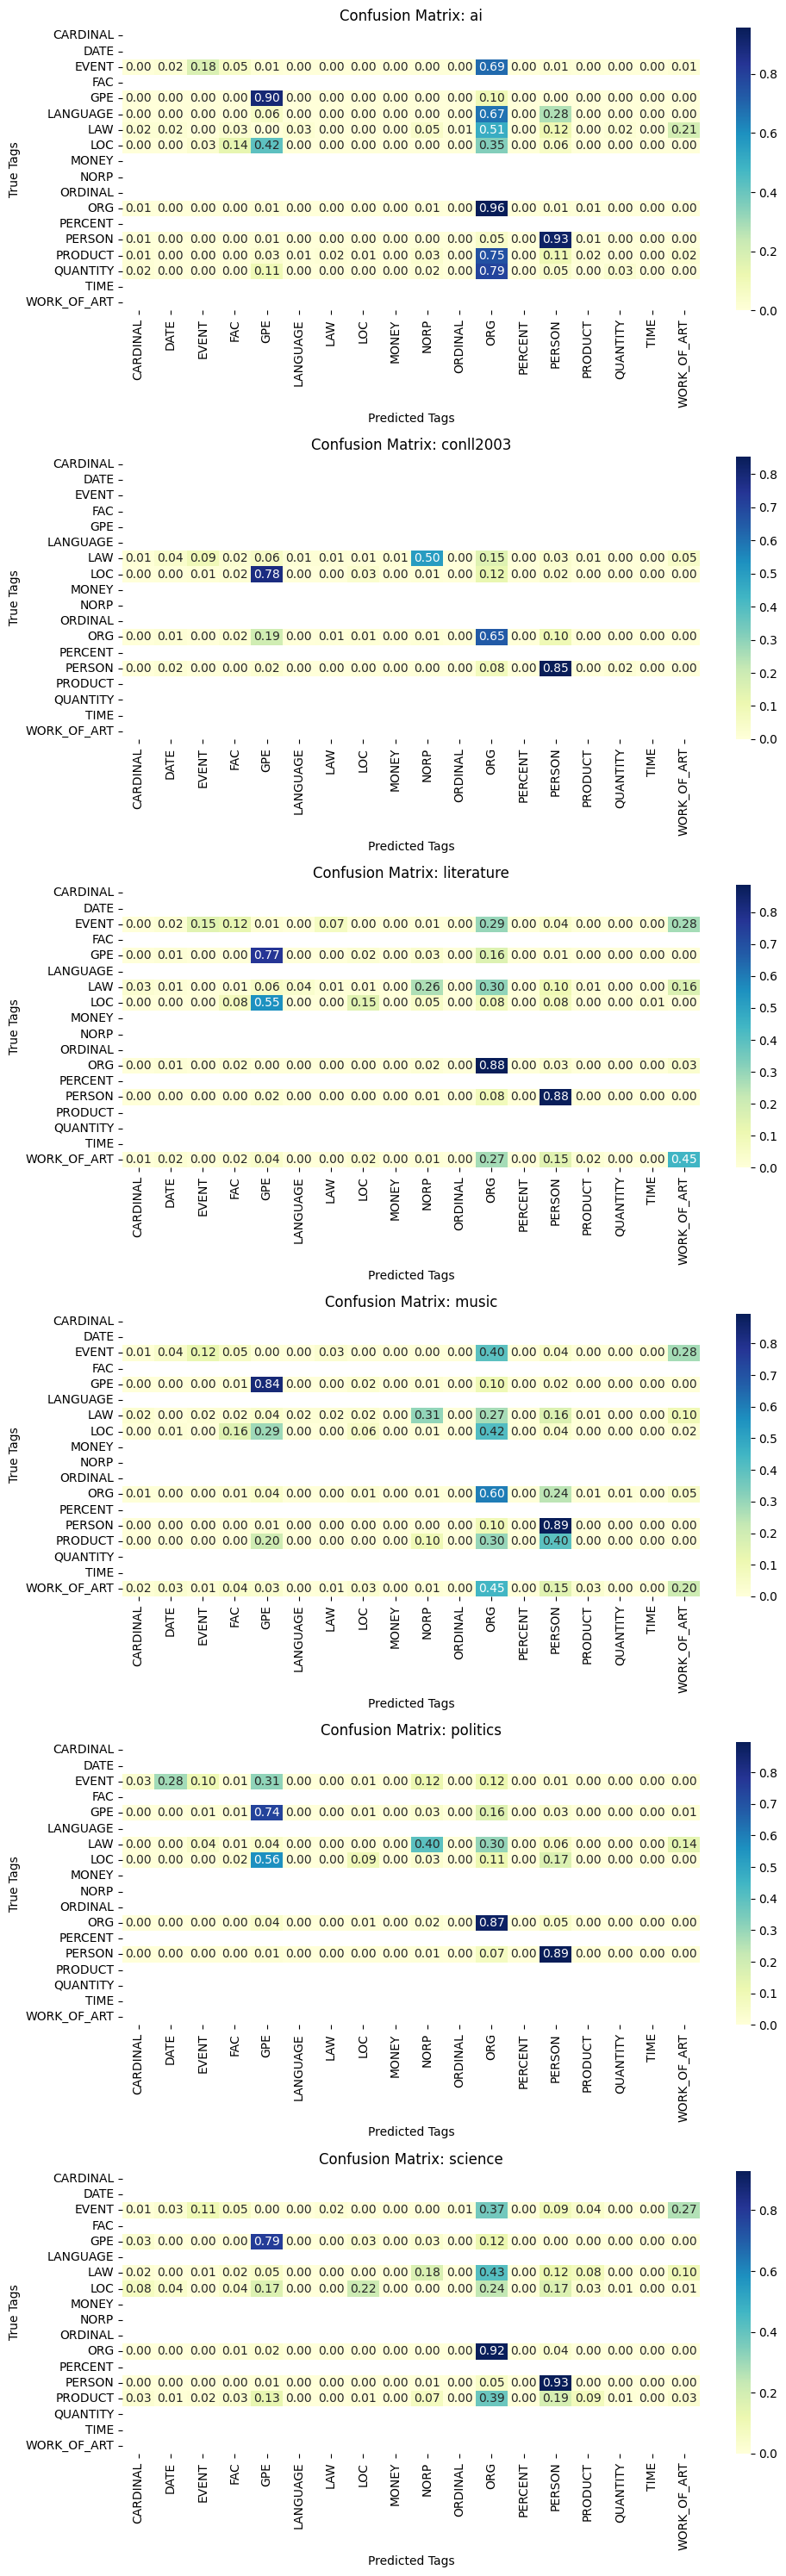

In [419]:
# Построение матриц конфузий
plot_confusion_matrices_spacy_with_domains(annotations, domains)

Что тут стоит отметить: практически во всех доменах мы замечаем одни и те же тенденции, а именно: 

1. мы обозначили достаточно разнообразные теги, но большинство из них определяется в большей части как организация. Напримар, мы чаще предсказываем то, что было продуктом или правом, или даже локацией - как организацию. 

2. Мы достаточно хорошо сметчили 2 сущности: организацию и человека, интересно что так же хорошо метчится GPE для всех доменов крому conll2003. Интересно что для него есть метч между предсказанным GPE и настоящим LOC.

3. Предсказываемое разнообразие очень мало: чаще всего мы предсказываем  5 категорий: организация, GPE, человек, Norp и совсем немного work of art.

### Classification report by domain and tag

In [67]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics_per_domain(annotations, domains):
    """
    Рассчитывает метрики Precision, Recall и F1-score по каждому тегу для каждого домена.
    Возвращает DataFrame с результатами.
    """
    results = []
    
    for domain in domains:
        # Отбираем аннотации для текущего домена
        domain_annotations = [ann for ann in annotations if ann["domain"] == domain]
        
        if not domain_annotations:
            print(f"Данные для домена '{domain}' отсутствуют.")
            continue
        
        # Составляем списки золотых и предсказанных тегов
        y_true = []
        y_pred = []
        for ann in domain_annotations:
            y_true.extend(ann["gold_tags"])
            y_pred.extend(ann["predicted_tags"])
        
        # Рассчитываем отчёт по классификации
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        
        # Преобразуем в формат DataFrame
        for tag, metrics in report.items():
            if tag in ["accuracy", "macro avg", "weighted avg"]:
                continue
            results.append({
                "Domain": domain,
                "Tag": tag,
                "Precision": metrics["precision"],
                "Recall": metrics["recall"],
                "F1-score": metrics["f1-score"],
                "Support": metrics["support"]
            })
    
    # Преобразуем результаты в DataFrame
    return pd.DataFrame(results)

In [68]:
def plot_combined_heatmaps(metrics_df, domains, metrics=["Precision", "Recall", "F1-score"], ncols = 2):
    """
    Строит тепловые карты для каждого домена с Precision, Recall и F1-score в одной таблице.
    """
    # Создаем сетку 3x2
    rows = (len(domains) + ncols - 1) // ncols  # Количество строк
    # print(rows)
    fig, axes = plt.subplots(rows, ncols, figsize=(10, rows * 6))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx, domain in enumerate(domains):
        ax = axes[idx]

        # Фильтруем данные для текущего домена
        domain_data = metrics_df[metrics_df["Domain"] == domain]

        # Преобразуем данные для heatmap
        heatmap_data = domain_data.pivot(index="Tag", columns="Metric", values="Value")
        
        # Создаем heatmap
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".2f",
            cmap="YlOrBr",
            cbar=True if idx % 2 == 1 else False,  # Добавляем colorbar только для второго столбца
            ax=ax
        )
        ax.set_title(f"Classification Report for {domain}")
        ax.set_xlabel("Metrics")
        ax.set_ylabel("Classes")
    
    # Отключаем пустые графики, если доменов меньше, чем ячеек
    for idx in range(len(domains), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


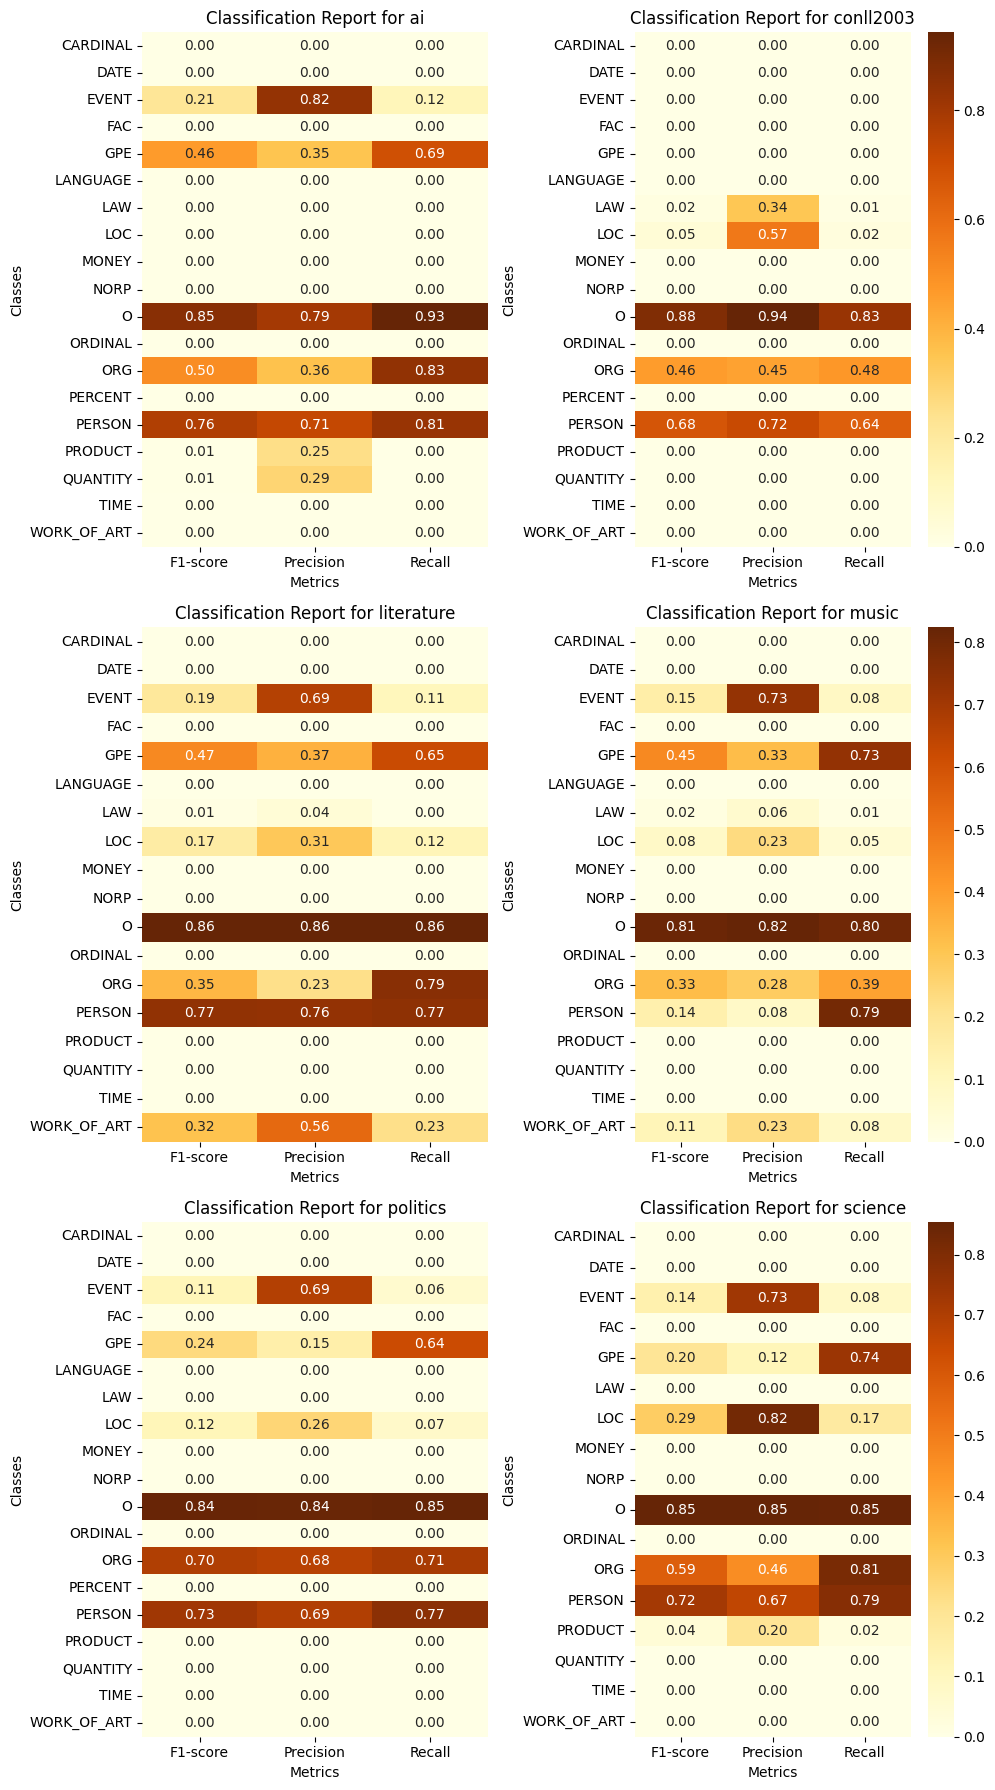

In [420]:
# Подготовка данных
metrics_expanded = pd.melt(
    calculate_metrics_per_domain(annotations, domains),
    id_vars=["Domain", "Tag"],
    value_vars=["Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Value"
)

# Построение тепловых карт
plot_combined_heatmaps(metrics_expanded, domains)

По полным метрикам в соответствии с каждым тегом по доменам мы видим, что основной вклад в метрику действительно делается только O тегом, иногда к нему подключаются Person и еще чуть реже Org. Это говорит о том, что усредненная точность у нас 70 процентов, просто потому что O - это весомое большинство, а person и org - достаточно легко определяемы, в отличие от всех наших остальных кастомных тегов.

И чуть-чуть хорошо себя показывает GPE (но не в conll2003), но прям совсем чуть-чуть. Интересно, что именно recall у него сильно высокий, а остальные метрики низкие. Высокий recall у GPE при низком precision указывает на широкие, но недостаточно точные шаблоны, которые находят большинство сущностей, но включают много ложноположительных.

А у Event другая история, чаще всего у него именно precision высокий. Для Event важно улучшить покрытие шаблонов (увеличить recall), сохранив высокую точность за счёт строгих фильтров. Высокий precision у Event при низком recall говорит о строгих правилах, которые находят сущности с высокой точностью, но пропускают многие из них.

## Ближе глянем на одну категорию в отдельности: 

In [70]:
from collections import defaultdict

def collect_unique_tags_by_domain(dataset, domains):
    """
    Собирает все уникальные теги (tags_named) по доменам из датасета.

    Args:
    - dataset (dict): словарь с разделами (train, test, val).
    - domains (list): список доменов.

    Returns:
    - dict: ключи - домены, значения - уникальные теги (set).
    """
    unique_tags_by_domain = defaultdict(set)

    for split, data in dataset.items():
        for example in data:
            domain = example["source"]
            if domain in domains:
                unique_tags_by_domain[domain].update(example["tags_named"])
    
    return unique_tags_by_domain

# Пример использования
domains = ["ai", "conll2003", "literature", "music", "politics", "science"]
unique_tags = collect_unique_tags_by_domain(dataset, domains)
unique_tags["ai"]

{'B-algorithm',
 'B-conference',
 'B-country',
 'B-field',
 'B-location',
 'B-metrics',
 'B-misc',
 'B-organisation',
 'B-person',
 'B-product',
 'B-programlang',
 'B-researcher',
 'B-task',
 'B-university',
 'I-algorithm',
 'I-conference',
 'I-country',
 'I-field',
 'I-location',
 'I-metrics',
 'I-misc',
 'I-organisation',
 'I-person',
 'I-product',
 'I-programlang',
 'I-researcher',
 'I-task',
 'I-university',
 'O'}

пропишем чисто для этой категории переходы к соответствующим базовым лейблам

Уточнение, про ai мы помним из EDA, что тег типа 'B-misc' и 'I-misc' похоже больше на продукты, чем на что-то другое, поэтому: 

In [124]:
ai_to_base_mapping = {
    "B-algorithm": "PRODUCT",
    "I-algorithm": "PRODUCT",
    "B-conference": "EVENT",
    "I-conference": "EVENT",
    "B-country": "GPE",
    "I-country": "GPE",
    "B-field": "WORK_OF_ART",
    "I-field": "WORK_OF_ART",
    "B-location": "LOC",
    "I-location": "LOC",
    "B-metrics": "QUANTITY",
    "I-metrics": "QUANTITY",
    "B-misc": "PRODUCT",
    "I-misc": "PRODUCT",
    "B-organisation": "ORG",
    "I-organisation": "ORG",
    "B-person": "PERSON",
    "I-person": "PERSON",
    "B-product": "PRODUCT",
    "I-product": "PRODUCT",
    "B-programlang": "PRODUCT",
    "I-programlang": "PRODUCT",
    "B-researcher": "PERSON",
    "I-researcher": "PERSON",
    "B-task": "WORK_OF_ART",
    "I-task": "WORK_OF_ART",
    "B-university": "ORG",
    "I-university": "ORG",
    "O": "O"
}


In [125]:
# Укажите домен, который нужно обработать
selected_domain = ["ai"]

# Применение функции к одному домену
metrics_df_var1, annotations_var1 = evaluate_ner_per_domain(dataset["val"], rb_model, ai_to_base_mapping, selected_domain)

Обрабатываем домен: ai


Уникальные теги: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


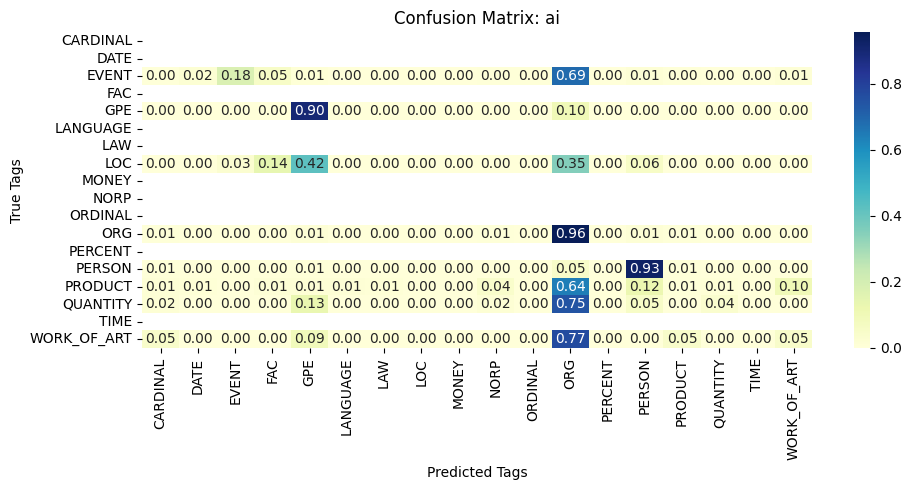

In [126]:
plot_confusion_matrices_spacy_with_domains(annotations_var1, ["ai"])

У нас все так же остаются 3 неизменные лидера, которые хорошо предсказываются - это ORG, PERSON, GPE

Про ORG, видно, что мы используем различные классы для всего, что просто идентифицировалось как ORG в предикте.

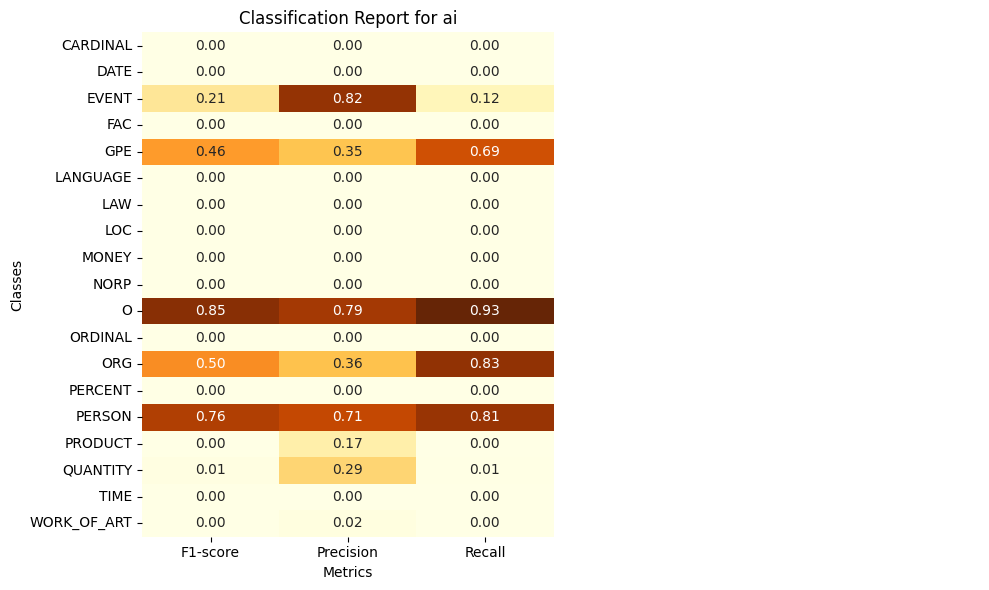

In [127]:
metrics_expanded_var1 = pd.melt(
    calculate_metrics_per_domain(annotations_var1, ["ai"]),
    id_vars=["Domain", "Tag"],
    value_vars=["Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Value"
)

# Построение тепловых карт
plot_combined_heatmaps(metrics_expanded_var1, ["ai"])

ORG: видно, что здесь мы неплохо справляемся с тем, чтобы находить все случаи, относящиеся к организациям (recall 0.83), однако precision (0.36) оставляет желать лучшего. Это значит, что часто к этому классу ошибочно причисляются другие объекты.

PERSON: тут результаты в целом хорошие, как по precision 0.71, так и по recall 0.81). Модель уверенно находит людей и делает это с неплохой точностью.

GPE: recall на уровне 0.69 показывает, что модель может найти большую часть объектов этого класса. Precision же 0.35 намекает на то, что иногда классификатор путает, добавляя лишние элементы в этот класс.

Что будет если мы чуть поменяем, например заменим все WORK OF ART теги на ORG?

In [128]:
ai_to_base_mapping = {
    "B-algorithm": "PRODUCT",
    "I-algorithm": "PRODUCT",
    "B-conference": "ORG",
    "I-conference": "ORG",
    "B-country": "GPE",
    "I-country": "GPE",
    "B-field": "ORG",
    "I-field": "ORG",
    "B-location": "LOC",
    "I-location": "LOC",
    "B-metrics": "ORG",
    "I-metrics": "ORG",
    "B-misc": "PRODUCT",
    "I-misc": "PRODUCT",
    "B-organisation": "ORG",
    "I-organisation": "ORG",
    "B-person": "PERSON",
    "I-person": "PERSON",
    "B-product": "PRODUCT",
    "I-product": "PRODUCT",
    "B-programlang": "PRODUCT",
    "I-programlang": "PRODUCT",
    "B-researcher": "PERSON",
    "I-researcher": "PERSON",
    "B-task": "ORG",
    "I-task": "ORG",
    "B-university": "ORG",
    "I-university": "ORG",
    "O": "O"
}

In [129]:
# Укажите домен, который нужно обработать
selected_domain = ["ai"]

# Применение функции к одному домену
metrics_df_var2, annotations_var2 = evaluate_ner_per_domain(dataset["val"], rb_model, ai_to_base_mapping, selected_domain)

Обрабатываем домен: ai


Уникальные теги: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


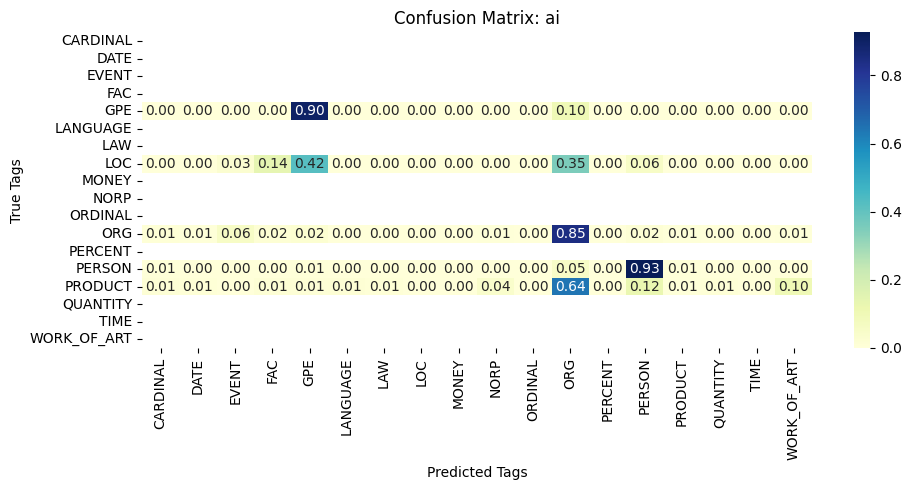

In [130]:
plot_confusion_matrices_spacy_with_domains(annotations_var2, ["ai"])

Действительно, пересечений тегов с тегом ORG стало меньше. Это ошибка первого рода в генерации соответствующих тегов, вместо этого мы сводим их всех к ORG, что некорректно. Мы можем еще уменьшать разнообразие выбранных тегов, но это не та стратегия, которая нам интересна. 

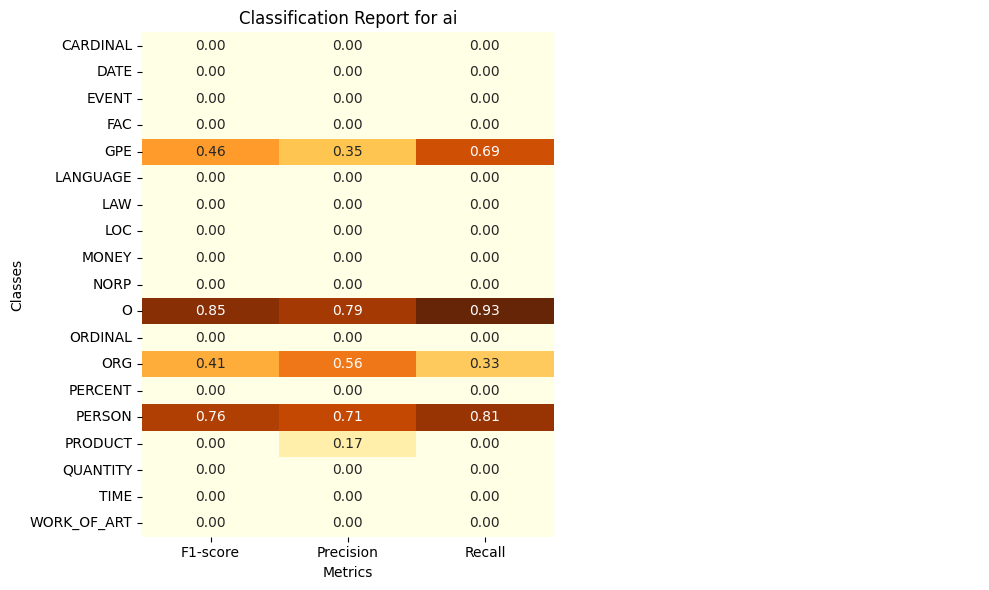

In [131]:
metrics_expanded_var2 = pd.melt(
    calculate_metrics_per_domain(annotations_var2, ["ai"]),
    id_vars=["Domain", "Tag"],
    value_vars=["Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Value"
)

# Построение тепловых карт
plot_combined_heatmaps(metrics_expanded_var2, ["ai"])

ORG: Precision вырос до 0.56, но Recall упал до 0.33. Модель стала более точной в определении организаций, но теперь пропускает больше объектов этого класса.

GPE: Метрики практически не изменились. Recall остался на уровне 0.69, а Precision — 0.35.

PERSON: Метрики остались стабильными: Precision 0.71, Recall 0.81. Это все еще сильная сторона модели.

O: Результаты немного ухудшились: Precision остался на уровне 0.79, но F1-score и Recall чуть снизились.

Остальные классы: Все еще остаются на нуле по большинству метрик, что говорит о том, что модель их практически не классифицирует.

## Custom rules fo ai

Давайте сначала глянем на то, как выглядят, из чего состоят те или иные теги:

In [77]:
def get_tags_for_domain(dataset, domains):
    tags = {}

    for domain in domains:
        # Инициализируем словарь для текущего домена
        domain_tags = defaultdict(list)

        # Пройтись по всем записям в тренировочном, валидационном и тестовом наборах
        for split in ["train"]:
            for example in dataset[split].filter(lambda x: x["source"] == domain):
                words = example["tokens"]
                ner_tags = example["tags_named"]

                current_tag = None
                current_element = []

                for word, tag in zip(words, ner_tags):
                    if tag.startswith("B-"):
                        # Если начинается новый тег
                        if current_tag:  # Если был предыдущий элемент, сохранить его
                            domain_tags[current_tag].append(" ".join(current_element))
                        current_tag = tag[2:]  # Убираем "B-"
                        current_element = [word]
                    elif tag.startswith("I-") and current_tag:
                        # Продолжаем текущий элемент
                        current_element.append(word)
                    else:
                        # Если тег "O" или вне последовательности, сохраняем предыдущий
                        if current_tag:
                            domain_tags[current_tag].append(" ".join(current_element))
                        current_tag = None
                        current_element = []

                # Добавляем последний элемент, если он не сохранён
                if current_tag:
                    domain_tags[current_tag].append(" ".join(current_element))

        # Добавляем словарь для текущего домена в общий словарь
        tags[domain] = domain_tags
    return tags

In [96]:
tags = get_tags_for_domain(dataset, ["ai"])

А так же глянем 10 самый частотных тегов, чтобы написать для них адаптированные правила:

In [94]:
from collections import Counter

# Инициализация словаря для хранения популярных тегов по доменам
popular_tags_per_domain = {}

# Проходим по всем доменам
for domain in domains:
    tag_counter = Counter()
    
    # Фильтруем записи по текущему домену
    for split in ["train"]:
        for example in dataset[split].filter(lambda x: x["source"] == domain):
            # Извлекаем теги и удаляем B- и I-
            tags = [tag[2:] if tag.startswith(("B-", "I-")) else tag for tag in example["tags_named"]]
            tag_counter.update(tags)
    
    # Получаем 5 самых популярных тегов
    popular_tags_per_domain[domain] = tag_counter.most_common(10)
popular_tags_per_domain["ai"]


[('O', 2614),
 ('algorithm', 173),
 ('organisation', 132),
 ('task', 124),
 ('product', 117),
 ('misc', 108),
 ('researcher', 96),
 ('conference', 94),
 ('university', 89),
 ('field', 82)]

O - это общий тег, мы видели выге, что тег organisation распознается достаточно хорошо. остальное - надо добавить правила. Например, с тегом product:

In [122]:
tags["ai"]["product"]

['opinion-based recommender system',
 'Octave',
 'MATLAB',
 'Google Translate',
 'SYSTRAN system',
 'BabelFish',
 'Babelfish',
 'RapidMiner',
 'tity',
 'Weka 3',
 'Eurisko',
 "Apple 's Siri",
 'Amazon Alexa',
 'Google Assistant',
 'Microsoft Cortana',
 "Samsung 's Bixby",
 'Voice Portals',
 'Far Field voice smart speakers',
 'Amazon Echo',
 'Google Home',
 'CINT',
 'Cling',
 'MATLAB',
 'Voice user interfaces',
 'Windows desktop systems',
 'SAPI 4',
 'SAPI 5',
 'artificially intelligent robots',
 'palletizing robot',
 'Programmable Universal Machine for Assembly',
 'expert system',
 'eSpeak synthesizer',
 'MATLAB',
 'DeepFace',
 'Trainable Pedestrian Detection system',
 '.NET',
 'JShell',
 'codejshell',
 'Knowledge Graphs',
 'Grammar checkers',
 'word processor',
 'MATLAB',
 'industrial robot',
 'Unimate',
 'AGV',
 'Motivity control system',
 'ADAM iAGV',
 'gantry systems',
 'industrial robot arms',
 'industrial robot',
 'PCNNs',
 'Programmable Universal Machine for Assembly',
 'J48',
 

In [80]:
import spacy
from spacy.matcher import Matcher

# Загрузка модели SpaCy
nlp = spacy.load("en_core_web_md")

# Инициализация Matcher
matcher = Matcher(nlp.vocab)

# Пример паттернов для кастомных тегов "product"
patterns = [
    [{"TEXT": {"REGEX": r"^[A-Z][a-zA-Z0-9\-' ]*$"}}],  # Название продуктов
    [{"TEXT": {"REGEX": r".*\b(system|tool|suite|robot|interface|speaker|synthesizer)\b.*"}}],  # Продуктовые ключевые слова
    [{"TEXT": {"REGEX": r"^[A-Z][a-z]+\b( [A-Z][a-z]+)*$"}}]  # Составные названия
]

# Добавляем шаблоны в Matcher
matcher.add("product", patterns)

# Пример текста
text = """
Google Translate and MATLAB are popular tools. Amazon Alexa and Adobe Creative Suite
are products widely used. Unimate is an industrial robot, and Voice user interfaces like 
Google Home are becoming common.
"""

# Применяем Matcher
doc = nlp(text)
matches = matcher(doc)

# Вывод результатов
for match_id, start, end in matches:
    span = doc[start:end]
    print(f"Tag: {nlp.vocab.strings[match_id]}, Match: {span.text}")

Tag: product, Match: Google
Tag: product, Match: Translate
Tag: product, Match: MATLAB
Tag: product, Match: Amazon
Tag: product, Match: Alexa
Tag: product, Match: Adobe
Tag: product, Match: Creative
Tag: product, Match: Suite
Tag: product, Match: Unimate
Tag: product, Match: robot
Tag: product, Match: Voice
Tag: product, Match: Google
Tag: product, Match: Home


** Итерационно делаем это для выбранных тегов из трейн части для домена AI

In [135]:
# Загрузка базовой модели SpaCy
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_md")

# Инициализация Matcher
matcher = Matcher(nlp.vocab)

# Уникальные шаблоны для кастомных тегов
patterns = {
    "algorithm": [
        [{"TEXT": {"REGEX": r"^\b.*algorithm\b.*$"}}],  # Содержит слово "algorithm"
        [{"TEXT": {"REGEX": r"^[A-Z]{2,5}$", "NOT_IN": ["CVPR", "NIPS", "SIGGRAPH"]}}],  # Аббревиатуры, исключая конференции
        [{"TEXT": {"REGEX": r"^\b(neural network|gradient descent|backpropagation|principal component analysis|support vector machine|linear discriminant analysis)\b$"}}],
        [{"TEXT": {"REGEX": r"^\b(matrix|function|factorization|least squares|Markov model)\b$"}}]
    ],
    "conference": [
        [{"TEXT": {"REGEX": r"^\b.*(Conference|Symposium|Workshop|Meeting|Congress|Vision)\b.*$"}}],  # Полные названия конференций
        [{"TEXT": {"REGEX": r"^[A-Z]{2,5}$", "IN": ["CVPR", "NIPS", "SIGGRAPH", "ICCV", "ACCV", "AAAI"]}}],  # Конкретные аббревиатуры конференций
        [{"TEXT": {"REGEX": r"^\b(19[0-9]{2}|20[0-9]{2})\b$"}}],  # Годы (для конференций с указанием года)
    ],
    "misc": [
        [{"TEXT": {"REGEX": r"^\b.*award\b.*$"}}],  # Содержит "award"
        [{"TEXT": {"REGEX": r"^\b(project|representation|ontology|tensor|heuristic)\b$"}}],  # Специфические термины
        [{"TEXT": {"REGEX": r"^\b(topological|dimensional|polynomial-based)\b$"}}],  # Научные термины
    ],
    "task": [
        [{"TEXT": {"REGEX": r"^\b.*(analysis|recognition|retrieval|synthesis|generation|classification)\b.*$"}}],  # Основные задачи
        [{"TEXT": {"REGEX": r"^\b(task|tasks)\b$"}}],  # Содержит "task" или "tasks"
    ],
    "product": [
        [{"TEXT": {"REGEX": r"^[A-Z][a-zA-Z0-9\-' ]*$"}}],  # Названия продуктов
        [{"TEXT": {"REGEX": r"^\b(system|tool|robot|suite|interface|speaker|synthesizer)\b$"}}],  # Продуктовые ключевые слова
    ],
    "researcher": [
        [{"TEXT": {"REGEX": r"^[A-Z]\.[A-Z]\.?\s[A-Za-z\-]+$"}}],  # Два инициала и фамилия
        [{"TEXT": {"REGEX": r"^[A-Z]\.[A-Z]?\.?\s[A-Za-z\-]+$"}}],  # Один или два инициала и фамилия
        [{"TEXT": {"REGEX": r"^[A-Z][a-z]+\s[A-Z][a-zA-Z\-]+$"}}],  # Полное имя
        [{"TEXT": {"REGEX": r"^[A-Z][a-zA-Z\-]+$"}}]  # Только фамилия
    ],
    "metrics": [
        [{"LOWER": {"REGEX": r"^(accuracy|precision|recall|f1[-\s]?score|auc|rmse|mae)$"}}]  # Метрики
    ],
    "person": [
        [{"TEXT": {"REGEX": r"^[A-Z][a-z]+\s[A-Z][a-z]+$"}}],  # Имя и фамилия
        [{"TEXT": {"REGEX": r"^[A-Z][a-z]+\s[A-Z][a-z]+\s[A-Z][a-z]+$"}}]  # Полное имя из трёх слов
    ],
    "location": [
        [{"ENT_TYPE": "LOC"}]  # Локации (места)
    ],
    "organisation": [
        [{"ENT_TYPE": "ORG"}]  # Организации
    ],
    "programlang": [
        [{"LOWER": {"REGEX": r"^(python|java|c\+\+|c#|javascript|typescript|ruby|go|rust|scala|php|perl)$"}}],  # Основные языки программирования
        [{"LOWER": {"REGEX": r"^(matlab|r|sql|bash|julia|fortran|cobol)$"}}]  # Другие языки
    ],
    "university": [
        [{"LOWER": {"REGEX": r"(university|college|institute|academy|school|polytechnic)"}}],
        [{"LOWER": {"REGEX": r"(mit|harvard|stanford|oxford|cambridge|berkeley|caltech|princeton)"}}],  # Известные университеты
        [{"LOWER": {"REGEX": r"(national university of|state university of|university of [a-z]+)"}}]
    ],
    "field": [
        [{"LOWER": {"REGEX": r"^(computer vision|natural language processing|nlp|ai|deep learning|data science)$"}}]  # Поля исследований
    ]
}

# Добавление правил в Matcher
for label, pattern_list in patterns.items():
    matcher.add(label.upper(), pattern_list)

In [136]:
from spacy import displacy

def visualize_with_both_annotations(dataset, nlp, matcher, domain="ai", sample_size=1):
    """
    Визуализирует примеры из указанного домена:
    1. С кастомной разметкой, сгенерированной правилами.
    2. С оригинальной разметкой из данных.

    Args:
    - dataset (Dataset): Train часть датасета.
    - domain (str): Название домена для выборки.
    - sample_size (int): Количество примеров для визуализации.
    """
    def clean_tag(tag):
        """Преобразует тег в универсальный формат (без B- и I-) и приводит в верхний регистр."""
        return tag.split("-", 1)[-1].upper() if "-" in tag else tag.upper()

    samples = []
    for example in dataset["train"]:
        if example["source"] == domain:
            tokens = example["tokens"]
            tags = [clean_tag(tag) for tag in example["tags_named"]]  # Преобразуем теги в верхний регистр
            sentence = " ".join(tokens)
            samples.append({"tokens": tokens, "tags": tags, "sentence": sentence})
        if len(samples) >= sample_size:
            break

    # Обработка каждого примера
    for idx, sample in enumerate(samples, start=1):
        print(f"Обрабатываем пример {idx}:")
        print(f"Токены: {sample['tokens']}")
        print(f"Теги (оригинальные): {sample['tags']}")
        print(f"Предложение: {sample['sentence']}")
        print("-" * 50)

        # Применение SpaCy модели
        doc = nlp(sample["sentence"])

        # 1. Кастомная разметка
        custom_ents = []
        matches = matcher(doc)
        for match_id, start, end in matches:
            label = nlp.vocab.strings[match_id]
            custom_ents.append({
                "start": doc[start].idx,
                "end": doc[end - 1].idx + len(doc[end - 1]),
                "label": label.upper()  # Приводим к верхнему регистру для консистентности
            })

        # 2. Оригинальная разметка
        original_ents = []
        current_char_index = 0
        for token, tag in zip(sample["tokens"], sample["tags"]):
            if tag != "O":  # Пропускаем тег O
                start_idx = current_char_index
                end_idx = current_char_index + len(token)
                original_ents.append({"start": start_idx, "end": end_idx, "label": tag})
            current_char_index += len(token) + 1  # Смещаем индекс с учетом пробела

        # Удаляем дублирующиеся сущности
        custom_ents = list({f"{ent['start']}-{ent['end']}-{ent['label']}": ent for ent in custom_ents}.values())
        original_ents = list({f"{ent['start']}-{ent['end']}-{ent['label']}": ent for ent in original_ents}.values())

        # Визуализация с кастомной разметкой
        displacy.render({"text": doc.text, "ents": custom_ents, "title": f"Custom NER Tags: Example {idx}"}, style="ent", manual=True, jupyter=True)

        # Визуализация с оригинальной разметкой
        displacy.render({"text": doc.text, "ents": original_ents, "title": f"Original NER Tags: Example {idx}"}, style="ent", manual=True, jupyter=True)

In [137]:
# Пример: визуализируем 1 пример из домена AI
visualize_with_both_annotations(dataset, nlp= nlp, matcher=matcher, domain="ai", sample_size=1)

Обрабатываем пример 1:
Токены: ['Popular', 'approaches', 'of', 'opinion-based', 'recommender', 'system', 'utilize', 'various', 'techniques', 'including', 'text', 'mining', ',', 'information', 'retrieval', ',', 'sentiment', 'analysis', '(', 'see', 'also', 'Multimodal', 'sentiment', 'analysis', ')', 'and', 'deep', 'learning', 'X.Y.', 'Feng', ',', 'H.', 'Zhang', ',', 'Y.J.', 'Ren', ',', 'P.H.', 'Shang', ',', 'Y.', 'Zhu', ',', 'Y.C.', 'Liang', ',', 'R.C.', 'Guan', ',', 'D.', 'Xu', ',', '(', '2019', ')', ',', ',', '21', '(', '5', ')', ':', 'e12957', '.']
Теги (оригинальные): ['O', 'O', 'O', 'PRODUCT', 'PRODUCT', 'PRODUCT', 'O', 'O', 'O', 'O', 'FIELD', 'FIELD', 'O', 'TASK', 'TASK', 'O', 'TASK', 'TASK', 'O', 'O', 'O', 'TASK', 'TASK', 'TASK', 'O', 'O', 'FIELD', 'FIELD', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', '

Итак полученные на этом этапе правила достаточно сильно между собой пересекаются, что очень плохо

## Правила с частями речи

Мы добавили части речи и немного донастроили разделение, чтобы добиться того, чтобы регулярные выражения не пересекались друг с другом.

In [491]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_md")

# Инициализация Matcher
matcher = Matcher(nlp.vocab)

# Уникальные шаблоны с учётом POS для кастомных тегов
patterns = {
    "algorithm": [
        [{"TEXT": {"REGEX": r"^\b.*algorithm\b.*$"}, "POS": "NOUN"}],  # Содержит слово "algorithm"
        [{"TEXT": {"REGEX": r"^(PCA|LDA|SVM|KNN|RNN|LSTM)$"}, "POS": "PROPN"}],  # Аббревиатуры алгоритмов
        [{"TEXT": {"REGEX": r"^\b(neural network|gradient descent|backpropagation|principal component analysis|support vector machine)\b$"}, "POS": "NOUN"}],
        [{"TEXT": {"REGEX": r"^\b(matrix|function|factorization|least squares|Markov model)\b$"}, "POS": "NOUN"}]  # Математические термины
    ],
    "conference": [
        [{"TEXT": {"REGEX": r"^\b.*(Conference|Symposium|Workshop|Meeting|Congress|Vision)\b.*$"}, "POS": "PROPN"}],  # Полные названия конференций
        [{"TEXT": {"REGEX": r"^(CVPR|NIPS|SIGGRAPH|ICCV|ACCV|AAAI)$"}, "POS": "PROPN"}],  # Аббревиатуры конференций
        [{"TEXT": {"REGEX": r"^\b(19[0-9]{2}|20[0-9]{2})\b$"}, "POS": "NUM"}]  # Годы конференций
    ],
    "misc": [
        [{"TEXT": {"REGEX": r"^\b.*award\b.*$"}, "POS": "NOUN"}],  # Содержит "award"
        [{"TEXT": {"REGEX": r"^\b(project|representation|ontology|tensor|heuristic)\b$"}, "POS": "NOUN"}],  # Специфические термины
        [{"TEXT": {"REGEX": r"^\b(topological|dimensional|polynomial-based)\b$"}, "POS": "ADJ"}],  # Научные термины
    ],
    "task": [
        [{"TEXT": {"REGEX": r"^\b.*(analysis|recognition|retrieval|synthesis|generation|classification)\b.*$"}, "POS": "NOUN"}],  # Основные задачи
        [{"TEXT": {"REGEX": r"^\b(task|tasks)\b$"}, "POS": "NOUN"}],  # Содержит "task" или "tasks"
    ],
    "university": [
        [{"LOWER": {"REGEX": r"(university|college|institute|academy|school|polytechnic)"}, "POS": "NOUN"}],
        [{"LOWER": {"REGEX": r"(mit|harvard|stanford|oxford|cambridge|berkeley|caltech|princeton)"}, "POS": "PROPN"}],  # Известные университеты
        [{"LOWER": {"REGEX": r"(national university of|state university of|university of [a-z]+)"}, "POS": "PROPN"}]
    ],
    "researcher": [
        [{"TEXT": {"REGEX": r"^[A-Z]\.[A-Z]\.?\s[A-Za-z\-]+$"}, "POS": "PROPN"}],  # Два инициала и фамилия
        [{"TEXT": {"REGEX": r"^[A-Z]\.[A-Z]?\.?\s[A-Za-z\-]+$"}, "POS": "PROPN"}],  # Один или два инициала и фамилия
        [{"TEXT": {"REGEX": r"^[A-Z][a-z]+\s[A-Z][a-zA-Z\-]+$"}, "POS": "PROPN"}],  # Полное имя
        [{"TEXT": {"REGEX": r"^[A-Z][a-zA-Z\-]+$"}, "POS": "PROPN"}]  # Только фамилия
    ],
    "product": [
        # [{"TEXT": {"REGEX": r"^[A-Z][a-zA-Z0-9\-' ]*$"}, "POS": "PROPN"}],  # Названия продуктов
        [{"TEXT": {"REGEX": r"^\b(system|tool|robot|suite|interface|speaker|synthesizer)\b$"}, "POS": "NOUN"}],  # Продуктовые ключевые слова
    ],
    "metrics": [
        [{"LOWER": {"REGEX": r"^(accuracy|precision|recall|f1[-\s]?score|auc|rmse|mae)$"}, "POS": "NOUN"}]  # Метрики
    ],
    "person": [
        [{"TEXT": {"REGEX": r"^[A-Z][a-z]+\s[A-Z][a-z]+$"}, "POS": "PROPN"}],  # Имя и фамилия
        [{"TEXT": {"REGEX": r"^[A-Z][a-z]+\s[A-Z][a-z]+\s[A-Z][a-z]+$"}, "POS": "PROPN"}]  # Полное имя из трёх слов
    ],
    "location": [
        [{"ENT_TYPE": "LOC", "POS": "PROPN"}]  # Локации (места)
    ],
    "organisation": [
        [{"ENT_TYPE": "ORG", "POS": "PROPN"}]  # Организации
    ],
    "programlang": [
        [{"LOWER": {"REGEX": r"^(python|java|c\+\+|c#|javascript|typescript|ruby|go|rust|scala|php|perl)$"}, "POS": "PROPN"}],  # Основные языки программирования
        [{"LOWER": {"REGEX": r"^(matlab|r|sql|bash|julia|fortran|cobol)$"}, "POS": "PROPN"}]  # Другие языки
    ],
    "field": [
        [{"LOWER": {"REGEX": r"^(computer vision|natural language processing|nlp|ai|deep learning|data science)$"}, "POS": "NOUN"}]  # Поля исследований
    ]
}

# Добавление правил в Matcher
for label, pattern_list in patterns.items():
    matcher.add(label.upper(), pattern_list)

## Показания, что правила друг другу не противоречат

In [147]:
visualize_with_both_annotations(dataset, nlp= nlp, matcher=matcher, domain="ai", sample_size=1)

Обрабатываем пример 1:
Токены: ['Popular', 'approaches', 'of', 'opinion-based', 'recommender', 'system', 'utilize', 'various', 'techniques', 'including', 'text', 'mining', ',', 'information', 'retrieval', ',', 'sentiment', 'analysis', '(', 'see', 'also', 'Multimodal', 'sentiment', 'analysis', ')', 'and', 'deep', 'learning', 'X.Y.', 'Feng', ',', 'H.', 'Zhang', ',', 'Y.J.', 'Ren', ',', 'P.H.', 'Shang', ',', 'Y.', 'Zhu', ',', 'Y.C.', 'Liang', ',', 'R.C.', 'Guan', ',', 'D.', 'Xu', ',', '(', '2019', ')', ',', ',', '21', '(', '5', ')', ':', 'e12957', '.']
Теги (оригинальные): ['O', 'O', 'O', 'PRODUCT', 'PRODUCT', 'PRODUCT', 'O', 'O', 'O', 'O', 'FIELD', 'FIELD', 'O', 'TASK', 'TASK', 'O', 'TASK', 'TASK', 'O', 'O', 'O', 'TASK', 'TASK', 'TASK', 'O', 'O', 'FIELD', 'FIELD', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', 'O', 'RESEARCHER', 'RESEARCHER', '

Мы видим, что мы стали предсказывать гораздо более точечно, и при этом без пересечений. 

## Немного метрик чисто для AI

In [493]:
metrics_df_ai, annotations_ai = evaluate_ner_per_domain(dataset["test"], nlp = nlp, matcher=matcher, domains = ["ai"])

Обрабатываем домен: ai


Filter: 100%|██████████| 5959/5959 [00:01<00:00, 4633.75 examples/s]


ДО:

In [516]:
metrics_df.iloc[0]

Domain             ai
Precision     0.21398
Recall       0.189376
F1-score     0.154434
Accuracy      0.72073
Name: 0, dtype: object

ПОСЛЕ:

In [517]:
metrics_df_ai.iloc[0]

Domain             ai
Precision    0.300829
Recall       0.205961
F1-score      0.18572
Accuracy      0.72835
Name: 0, dtype: object

Precision: Было 0.21398, стало 0.300829. Значительное улучшение — модель стала точнее в своих предсказаниях.

Recall: Подрос с 0.189376 до 0.205961. Прирост небольшой, но всё равно модель стала чуть лучше находить нужные объекты.

F1-score: Вырос с 0.154434 до 0.18572. Это логично, так как F1-score зависит и от precision, и от recall, оба немного подтянулись.

Accuracy: Поднялась с 0.72073 до 0.72835. Общая доля правильных предсказаний стала чуть выше.

ДО:

Уникальные теги: ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']


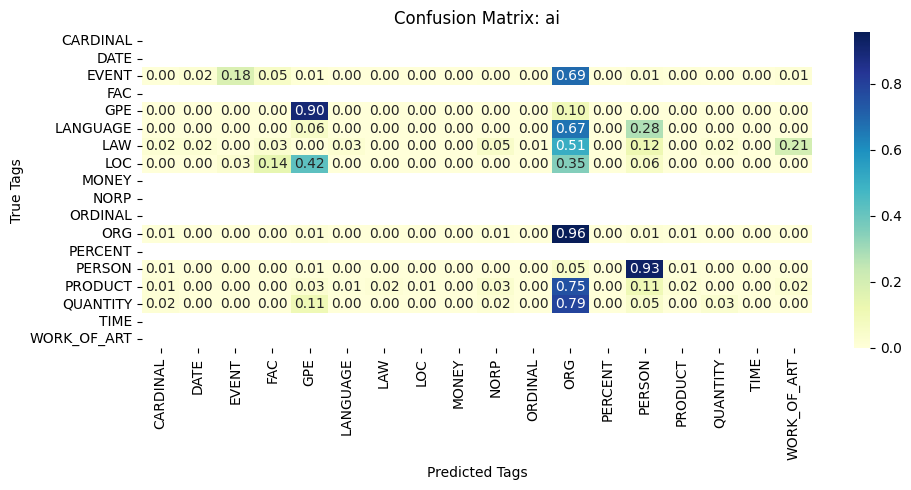

In [161]:
plot_confusion_matrices_spacy_with_domains(annotations, ["ai"])

ПОСЛЕ:

Уникальные теги: ['ALGORITHM', 'CONFERENCE', 'COUNTRY', 'FIELD', 'LOCATION', 'METRICS', 'MISC', 'ORGANISATION', 'PERSON', 'PRODUCT', 'PROGRAMLANG', 'RESEARCHER', 'TASK', 'UNIVERSITY']


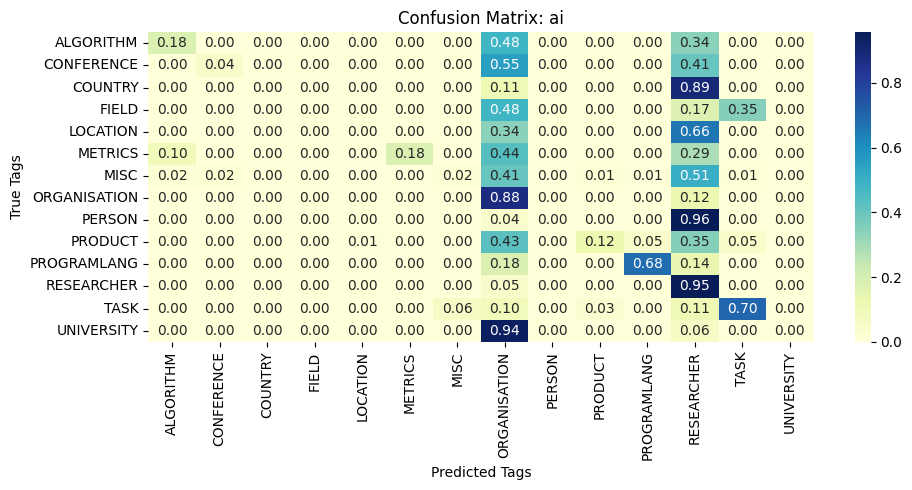

In [160]:
plot_confusion_matrices_spacy_with_domains(annotations_ai, ["ai"])

Так как у нас классы теперь не сильно пересекаются все что тут можно сказать, мы видим разброс теперь не только по организации, но и по ресерчеру, который сильно коррелирует с правдивым ресерчером, человеком и неожиданно, страной, хехе.

ДО:

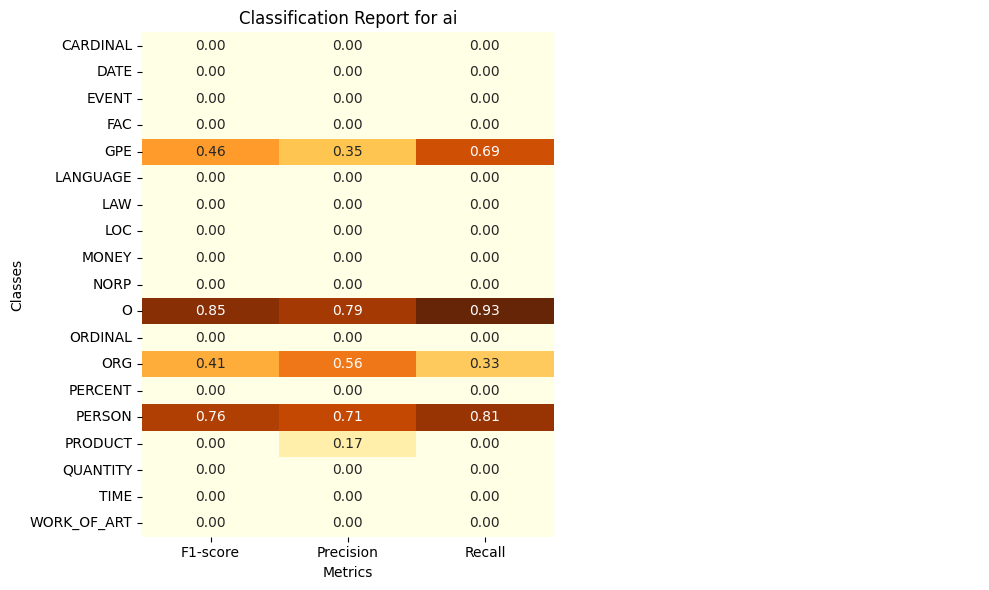

In [162]:
metrics_expanded_ai = pd.melt(
    calculate_metrics_per_domain(annotations, ["ai"]),
    id_vars=["Domain", "Tag"],
    value_vars=["Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Value"
)

# Построение тепловых карт
plot_combined_heatmaps(metrics_expanded, ["ai"])

ПОСЛЕ:

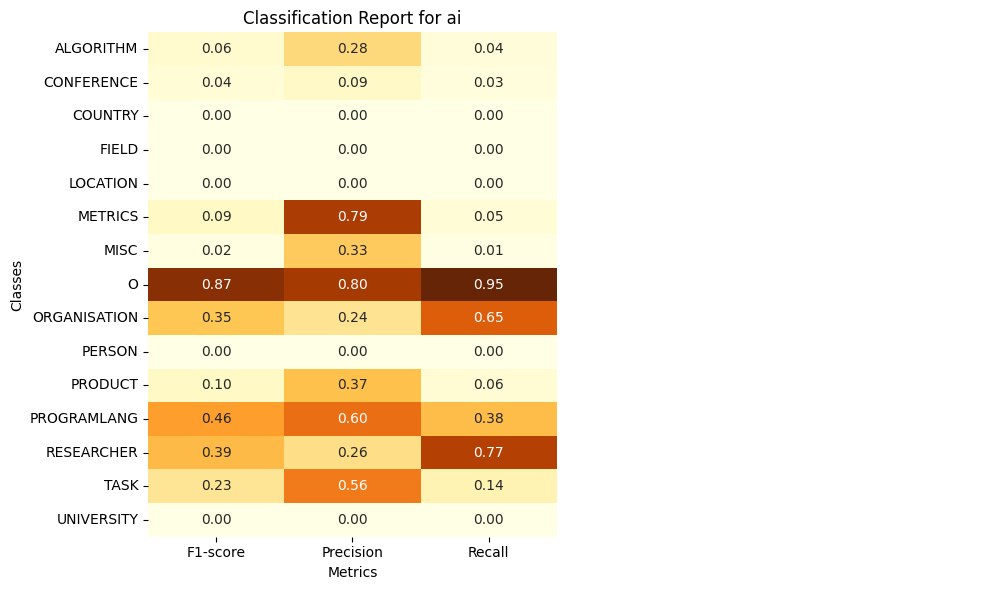

In [163]:
metrics_expanded_ai = pd.melt(
    calculate_metrics_per_domain(annotations_ai, ["ai"]),
    id_vars=["Domain", "Tag"],
    value_vars=["Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Value"
)

# Построение тепловых карт
plot_combined_heatmaps(metrics_expanded_ai, ["ai"])

O: Это прям топовый класс, всё ещё супер результаты — F1-score 0.87, precision 0.80, recall 0.95. Модель почти всегда правильно классифицирует "другие" элементы.

ORGANISATION: Тут не очень. Recall на 0.65 ещё терпимый, но precision 0.24 говорит, что модель часто ошибается и приписывает лишние объекты к этому классу.

PROGRAMLANG: Тут что-то получилось. Precision 0.60 — модель довольно точно определяет языки, но recall 0.38 показывает, что часть всё равно теряется.

RESEARCHER: Тоже неплохие результаты для редкого класса — recall 0.77, что даже удивляет. Но precision низкий — 0.26.

TASK: Очень разрыв по метрикам — модель угадывает что-то с precision 0.56, но recall всего 0.14. Получается, находит мало, но точно.

Остальные: Классы вроде PERSON, UNIVERSITY, COUNTRY вообще не зашли, всё почти на нуле.

# Neural Network

## Токенизация

In [421]:
TOKENIZER_PATH = "tokenizers/word_level_tokenizer_{tokens_name}.json"

### Обучение токенайзера на train и val

In [423]:
def get_lowercase_tokens(example):
    return {"tokens_lower": [token.lower() for token in example["tokens"]]}

for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].map(get_lowercase_tokens)

Map: 100%|██████████| 5959/5959 [00:00<00:00, 7962.16 examples/s] 


In [426]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from collections import Counter
import itertools

# Соберем все токены из train и val
def collect_all_tokens(datasets, tokens_name = "tokens_lower"):
    all_tokens = []
    for dataset in datasets:
        for tokens in dataset[tokens_name]:
            all_tokens.extend(tokens)
    return all_tokens

def get_tokenizer(tokens_name= "tokens_lower"):

    # Объединяем train и val
    all_tokens = collect_all_tokens([dataset["train"], dataset["val"]], tokens_name)

    # Подсчитываем частоты
    word_counts = Counter(all_tokens)
    word_counts

    # Создаём словарь: добавляем токен `<OOV>` для неизвестных слов
    MAX_WORDS_TOKENIZER = len(word_counts) + 2
    vocab = {"<PAD>": 0, "<OOV>": 1}  # Резервируем индексы 0 и 1 для PAD и OOV
    most_common = word_counts.most_common(MAX_WORDS_TOKENIZER - len(vocab))

    # Добавляем слова в словарь
    for i, (word, _) in enumerate(most_common, start=len(vocab)):
        vocab[word] = i

    # Создаем токенайзер WordLevel
    tokenizer = Tokenizer(WordLevel(vocab, unk_token="<OOV>"))
    tokenizer.pre_tokenizer = Whitespace()  # Токенизация по пробелам

    # Проверим токенизацию
    print(tokenizer.encode("This is an example sentence.").tokens)
    print(tokenizer.encode("This is an unknownword!").ids)

    # Сохранение токенайзера
    tokenizer.save(TOKENIZER_PATH.format(tokens_name = tokens_name))

In [427]:
get_tokenizer()
get_tokenizer("tokens")

['<OOV>', 'is', 'an', 'example', 'sentence', '.']
[1, 27, 34, 1, 2256]
['This', 'is', 'an', 'example', 'sentence', '.']
[265, 27, 34, 1, 2321]


In [428]:
# Функция для кодирования токенов с использованием токенайзера
def encode_dataset(dataset, tokenizer, max_len, tokens_name = "tokens_lower"):
    encoded_sequences = []
    for tokens in dataset[tokens_name]:
        # Кодируем последовательность
        encoded = tokenizer.encode(" ".join(tokens)).ids
        # Применяем паддинг или обрезку
        if len(encoded) > max_len:
            encoded = encoded[:max_len]  # Обрезаем до max_len
        else:
            encoded += [0] * (max_len - len(encoded))  # Паддинг токеном <PAD> (0)
        encoded_sequences.append(encoded)
    return np.array(encoded_sequences)
# Функция для кодирования тегов с паддингом


def encode_tags(dataset, max_len, pad_tag_id=0):
    encoded_tags = []
    for tags in dataset["ner_tags"]:
        # Если длина больше max_len, обрезаем
        if len(tags) > max_len:
            encoded = tags[:max_len]
        else:
            # Если длина меньше max_len, добавляем паддинг с использованием pad_tag_id
            encoded = tags + [pad_tag_id] * (max_len - len(tags))
        encoded_tags.append(encoded)
    return np.array(encoded_tags)

### Кодирование токенайзера

In [429]:
MAX_SEQUENCE_LENGTH = 128  # Максимальная длина последовательности
PAD_TAG_ID = 79  # Индекс для паддинга тегов

def filter_by_domain(dataset, domain):
    """
    Фильтрует датасет по поддомену.
    """
    return dataset.filter(lambda x: x["source"] == domain)

def get_tokenized_data(tokens_name = "tokens_lower"):
    tokenizer = Tokenizer.from_file(TOKENIZER_PATH.format(tokens_name = tokens_name))

    # Словарь для хранения закодированных данных по разбиениям и поддоменам
    encoded_datasets = defaultdict(lambda: defaultdict(dict))

    # Кодируем данные для каждого разбиения и поддомена
    for split_name, dataset_el in tqdm(dataset.items(), desc="Обработка по сплиту"):

        for domain in tqdm(domains, "Обработанные домены"):

            # Фильтруем датасет для текущего поддомена
            domain_dataset = filter_by_domain(dataset_el, domain)

            # Кодируем токены и теги
            tokens_matrix = encode_dataset(domain_dataset, tokenizer, MAX_SEQUENCE_LENGTH, tokens_name)
            tags_matrix = encode_tags(domain_dataset, MAX_SEQUENCE_LENGTH, PAD_TAG_ID)

            # Сохраняем кодированные данные
            encoded_datasets[split_name][domain] = {
                "input_ids": tokens_matrix,
                "labels": tags_matrix
            }

    return encoded_datasets

In [430]:
encoded_datasets = get_tokenized_data(tokens_name = "tokens")

# Проверка результата
split_name = "train"
domain = "ai"
print(f"{split_name} -> {domain} example input_ids:", encoded_datasets[split_name][domain]["input_ids"][0])
print(f"{split_name} -> {domain} example labels:", encoded_datasets[split_name][domain]["labels"][0])

Обработка по сплиту:   0%|          | 0/3 [00:00<?, ?it/s]






Filter: 100%|██████████| 14741/14741 [00:00<00:00, 16967.33 examples/s]







Filter: 100%|██████████| 14741/14741 [00:00<00:00, 17531.89 examples/s]







Filter: 100%|██████████| 14741/14741 [00:00<00:00, 17502.62 examples/s]







Filter: 100%|██████████| 14741/14741 [00:00<00:00, 17566.84 examples/s]







Filter: 100%|██████████| 14741/14741 [00:00<00:00, 17926.92 examples/s]







Обработка по сплиту:  33%|███▎      | 1/3 [00:06<00:13,  6.84s/it]


Filter: 100%|██████████| 5371/5371 [00:00<00:00, 11158.23 examples/s]



Filter: 100%|██████████| 5371/5371 [00:00<00:00, 11457.74 examples/s]




Filter: 100%|██████████| 5371/5371 [00:00<00:00, 10463.02 examples/s]



Filter: 100%|██████████| 5371/5371 [00:00<00:00, 12204.44 examples/s]



Filter: 100%|██████████| 5371/5371 [00:00<00:00, 12298.89 examples/s]



Обработка по сплиту:  67%|██████▋   | 2/3 [00:10<00:04,  4.73s/it]


Filter: 100%|██████████| 5959/5959 [

train -> ai example input_ids: [ 1684  9534     5  3058    19   441  7741   416 18356   973  2472   103
  1932  1761     2   879  5018     2  3734  1130    11   656    63 18357
  3734  1130    10     6  2634   597  3638     4  8850     4 12320     2
     1     4  9535     2  8850     4  8055     4  9536     2  5873     4
     1     4 18361     2  8850     4 12322     2  8850     4  1850     4
 18363     2  1938     4  1850     4 18365     2  1805     4  9537     2
    11  1326    10     2     2   262    11    57    10    31 18366     4
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
train -> ai example labels: [ 0  0  0 59 60 60  0  0  0  0 31 32  0 71 72  0 71 72  0  0  0 71 72 72
  0  0 31 32 65 66  0 65 66  0 65 66  0 65 66  0 65 66  0 65 66  0 65 66
  0 65 66  0  0

In [431]:
encoded_datasets_lowercase = get_tokenized_data()

Обработка по сплиту: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


In [432]:
# Проверка результата
split_name = "train"
domain = "ai"
print(f"{split_name} -> {domain} example input_ids:", encoded_datasets_lowercase[split_name][domain]["input_ids"][0])
print(f"{split_name} -> {domain} example labels:", encoded_datasets_lowercase[split_name][domain]["labels"][0])

train -> ai example input_ids: [  577  8765     5  2771    19   468  7185   381 16523   946  2284   110
  1810  1401     2   532  4733     2  3318  1095    11   652    64 16524
  3318  1095    10     6  1551   568  1500     4  2726     4 11209     2
     1     4  8766     2  2726     4  7455     4  8767     2  3421     4
     1     4 16528     2  2726     4 11211     2  2726     4   527     4
 16530     2  1753     4   527     4 16532     2  1261     4  8768     2
    11  1362    10     2     2   279    11    59    10    33 16533     4
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
train -> ai example labels: [ 0  0  0 59 60 60  0  0  0  0 31 32  0 71 72  0 71 72  0  0  0 71 72 72
  0  0 31 32 65 66  0 65 66  0 65 66  0 65 66  0 65 66  0 65 66  0 65 66
  0 65 66  0  0

Так мы закодировали численно наши датасеты с входными токенами и выходные теги, чтобы размерность была одинаковая. При этом, оставили домены отделенными, чтобы была возможность если что обучить отдельные модели.

Так же мы разделили два случай: первый, когда мы привели весь текст к lowercase формату и второй - оставили все как есть

## Модель для AI

In [171]:
encoded_datasets

defaultdict(<function __main__.<lambda>()>,
            {'train': defaultdict(dict,
                         {'ai': {'inputs': array([[ 1684,  9534,     5, ...,     0,     0,     0],
                                  [18367,     5, 18368, ...,     0,     0,     0],
                                  [   17,  2822,  7743, ...,     0,     0,     0],
                                  ...,
                                  [   17,   647,  4511, ...,     0,     0,     0],
                                  [  883,     2,     1, ...,     0,     0,     0],
                                  [ 1858,  6599,     2, ...,     0,     0,     0]]),
                           'labels': array([[ 0,  0,  0, ..., 79, 79, 79],
                                  [ 0,  0,  0, ..., 79, 79, 79],
                                  [ 0,  0,  0, ..., 79, 79, 79],
                                  ...,
                                  [ 0,  0, 31, ..., 79, 79, 79],
                                  [ 0,  0,  0, ..., 

In [220]:
encoded_datasets["val"]["ai"]

{'input_ids': array([[  959,     2,  1459, ...,     0,     0,     0],
        [   26,    54,  6398, ...,     0,     0,     0],
        [26448,   784, 10852, ...,     0,     0,     0],
        ...,
        [   91,  4484, 27115, ...,     0,     0,     0],
        [ 1318,   910,   974, ...,     0,     0,     0],
        [   91,  2473,  2958, ...,     0,     0,     0]]),
 'labels': array([[ 0,  0, 39, ..., 79, 79, 79],
        [ 0,  0,  0, ..., 79, 79, 79],
        [51, 52,  0, ..., 79, 79, 79],
        ...,
        [ 0,  0, 41, ..., 79, 79, 79],
        [31, 32, 32, ..., 79, 79, 79],
        [ 0,  0,  0, ..., 79, 79, 79]])}

## Init Model

In [442]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

BATCH_SIZE = 32
HIDDEN_DIM = 512

NUM_TAGS = len(tag2id)
PAD_TAG_ID = 79  # пример индекса паддинга

# Определим Dataset
class TokenDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        # Возвращаем тензоры
        return torch.tensor(self.input_ids[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [443]:
def load_glove_embeddings(glove_path, embedding_dim):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == embedding_dim:
                embeddings_index[word] = vector
    return embeddings_index

def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    vocab_size = tokenizer.get_vocab_size()
    count = 0
    # Вычислим средний вектор по всем известным эмбеддингам
    all_vectors = np.array(list(embeddings_index.values()))
    mean_vector = np.mean(all_vectors, axis=0)

    embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype='float32')
    for i in range(vocab_size):
        token = tokenizer.id_to_token(i)
        vector = embeddings_index.get(token)
        if vector is not None:
            embedding_matrix[i] = vector
        else:
            # Используем средний вектор для слов, которых нет в предобученных
            count +=1
            embedding_matrix[i] = mean_vector

    print("рандомно проинициализированных эмбеддингов: ", count)
    return embedding_matrix

def init_embeddings(tokens_name = "tokens_lower"):
    tokenizer = Tokenizer.from_file(TOKENIZER_PATH.format(tokens_name = tokens_name))

    # Пример использования:
    glove_path = "embeddings/glove.6B.300d.txt"
    embedding_dim = 300
    embeddings_index = load_glove_embeddings(glove_path, embedding_dim)

    embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, embedding_dim)

    return embedding_matrix, tokenizer, embedding_dim

In [444]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, num_tags, embedding_dim, hidden_dim, pad_token_id=0, pretrained_embeddings=None, freeze_embeddings=False):
        super(BiLSTMTagger, self).__init__()
        self.num_tags = num_tags
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id)
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # Добавляем Batch Normalization после LSTM
        self.bn = nn.BatchNorm1d(hidden_dim*2)
        
        self.fc = nn.Linear(hidden_dim*2, num_tags)

    def forward(self, input_ids):
        embeds = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]
        outputs, _ = self.lstm(embeds)      # [batch_size, seq_len, hidden_dim*2]

        # Применяем BatchNorm
        batch_size, seq_len, feature_dim = outputs.shape
        outputs_2d = outputs.reshape(-1, feature_dim)    # [batch_size*seq_len, feature_dim]
        outputs_bn = self.bn(outputs_2d)                 # нормализация по признакам
        outputs_bn = outputs_bn.reshape(batch_size, seq_len, feature_dim)  # возвращаем форму [batch_size, seq_len, feature_dim]

        logits = self.fc(outputs_bn)           # [batch_size, seq_len, num_tags]
        return logits


In [445]:
def init_model(tokenizer, embedding_matrix, current_model_class = BiLSTMTagger, embedding_dim = 300, hidden_dim = HIDDEN_DIM):
    model_in = current_model_class(
        vocab_size=tokenizer.get_vocab_size(),
        num_tags=NUM_TAGS,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        pad_token_id=0,
        pretrained_embeddings=embedding_matrix,
        freeze_embeddings=False
        )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_in.to(device)

    return model_in, device

ВАЖНО: мы размораживаем наши предобученные эмбеддинги: `freeze_embeddings=False`, потому что у нас есть часть эмбеддингов, которые мы инициализировали как среднее всех остальных, поэтому нам надо 

## Init metrics func

In [446]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_of_tags(true_tags, pred_tags, id2tag, pad_tag_id=79, figsize=(12,10), cmap="YlGnBu"):
    """
    Строит и отображает матрицу ошибок для предсказаний тегов.

    Параметры:
    -----------
    true_tags : list[int] или np.ndarray
        Список или массив истинных тегов (по всем токенам в датасете), где теги закодированы числами.
    pred_tags : list[int] или np.ndarray
        Список или массив предсказанных тегов того же размера, что и true_tags.
    id2tag : dict
        Словарь отображения индексов тегов в названия (строки).
    pad_tag_id : int, опционально
        Индекс паддингового тега, по умолчанию 79.
    figsize : tuple, опционально
        Размер фигуры (width, height).
    cmap : str, опционально
        Цветовая карта для тепловой карты.
    """

    # Преобразуем в np.array, если это не так
    true_tags = np.array(true_tags)
    pred_tags = np.array(pred_tags)

    # Маска для удаления паддинговых токенов
    mask = true_tags != pad_tag_id
    true_filtered = true_tags[mask]
    pred_filtered = pred_tags[mask]

    # Получим уникальные теги (исключая паддинг)
    unique_tags = sorted(set(true_filtered).union(set(pred_filtered)))

    # Построим матрицу ошибок
    cm = confusion_matrix(true_filtered, pred_filtered, labels=unique_tags)
    # Конвертируем индексы в строковые названия
    tag_names = [id2tag[i] for i in unique_tags]

    # Нормируем матрицу по строкам
    cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # Рисуем heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", xticklabels=tag_names, yticklabels=tag_names, cmap=cmap)
    ax.set_xlabel('Predicted Tags', fontsize=12)
    ax.set_ylabel('True Tags', fontsize=12)
    plt.title('Confusion Matrix of Tags', fontsize=14)

    plt.yticks(rotation=0)   # Делает ярлыки по оси Y горизонтальными
    plt.xticks(rotation=90)  # Поворот меток по оси X на 90° для удобного чтения
    plt.tight_layout()
    plt.show()

In [447]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics_from_samples(samples, pad_tag_id=79):
    """
    Принимает на вход результат работы generate_test_samples:
    {
        "true": [список истинных меток],
        "false": [список предсказанных меток]
    }
    и считает accuracy, macro F1, macro precision, macro recall.
    """

    all_true_tags = samples["true"]
    all_pred_tags = samples["false"]

    # Превратим в np.array для удобства
    import numpy as np
    all_true_tags = np.array(all_true_tags)
    all_pred_tags = np.array(all_pred_tags)

    # Удаляем паддинг
    mask = all_true_tags != pad_tag_id
    true_filtered = all_true_tags[mask]
    pred_filtered = all_pred_tags[mask]

    unique_tags = sorted(set(true_filtered).union(set(pred_filtered)))
    # Удалим паддинг, если вдруг там есть
    if pad_tag_id in unique_tags:
        unique_tags.remove(pad_tag_id)
    
    # Считаем метрики:
    # accuracy
    acc = accuracy_score(true_filtered, pred_filtered)
    # precision macro
    prec = precision_score(true_filtered, pred_filtered, labels=unique_tags, average='macro', zero_division=0)
    # recall macro
    rec = recall_score(true_filtered, pred_filtered, labels=unique_tags, average='macro', zero_division=0)
    # f1 macro
    f1 = f1_score(true_filtered, pred_filtered, labels=unique_tags, average='macro', zero_division=0)

    return {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    }

## Train process

In [452]:
MODEL_PATH = "models/best_model_{comment}.pt"

In [459]:
def train_process(embedding_matrix, tokenizer, embedding_dim, encoded_datasets, criterion = None, field = "ai", comment = "1_count", learning_rate = 0.001, num_epochs = 10, current_model_class = BiLSTMTagger):
    model, device = init_model(tokenizer, embedding_matrix, current_model_class = current_model_class, embedding_dim = embedding_dim)

    if not criterion:
        criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_ID)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = TokenDataset(encoded_datasets["train"][field]["input_ids"], encoded_datasets["train"][field]["labels"])
    val_dataset = TokenDataset(encoded_datasets["val"][field]["input_ids"], encoded_datasets["val"][field]["labels"])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(input_ids)  # [batch_size, seq_len, num_tags]
            loss = criterion(logits.view(-1, NUM_TAGS), labels.view(-1))

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, labels = batch
                input_ids = input_ids.to(device)
                labels = labels.to(device)
                logits = model(input_ids)
                loss = criterion(logits.view(-1, NUM_TAGS), labels.view(-1))
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        
        # Сохраняем модель, если улучшился результат на валидации
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_PATH.format(comment = comment))
            print(f"Epoch {epoch+1}/{num_epochs}: Val loss improved to {avg_val_loss:.4f}. Model saved.")
        else:
            print(f"Epoch {epoch+1}/{num_epochs}: Val loss did not improve from {best_val_loss:.4f}.")

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

In [467]:
def generate_test_samples(encoded_datasets, tokenizer, embedding_matrix, model_name, field = "ai", current_model_class = BiLSTMTagger, embedding_dim = 300):
    model_in, device = init_model(tokenizer, embedding_matrix, current_model_class = current_model_class, embedding_dim = embedding_dim)
    model_in.eval()
    model_in.load_state_dict(torch.load(MODEL_PATH.format(comment=model_name)))

    test_dataset = TokenDataset(encoded_datasets["test"][field]["input_ids"], encoded_datasets["test"][field]["labels"])
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    all_true_tags = []
    all_pred_tags = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            # Прогоняем модель
            logits = model_in(input_ids) # [batch_size, seq_len, num_tags]
            # Предсказанные теги - argmax по последней размерности
            predictions = torch.argmax(logits, dim=-1) # [batch_size, seq_len]

            # Перекладываем на CPU и в numpy
            pred_tags_batch = predictions.cpu().numpy()
            true_tags_batch = labels.cpu().numpy()

            # Раскладываем батчи в плоский список
            all_true_tags.extend(true_tags_batch.flatten())
            all_pred_tags.extend(pred_tags_batch.flatten())

    return {"true": all_true_tags, 'false': all_pred_tags}


## init embeddings

In [457]:
embedding_matrix_lower, tokenizer_lower, embedding_dim = init_embeddings(tokens_name="tokens_lower")
embedding_matrix, tokenizer, embedding_dim = init_embeddings(tokens_name="tokens")

рандомно проинициализированных эмбеддингов:  4675
рандомно проинициализированных эмбеддингов:  21876


## simple loss

In [ ]:
samples = {}

name = "simple"

train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = None, field="ai", comment=name + "_lower", num_epochs=50)
train_process(embedding_matrix, tokenizer, embedding_dim, encoded_datasets = encoded_datasets, criterion = None, field="ai", comment=name, num_epochs=50)

samples[name + "_lower"] = generate_test_samples(encoded_datasets_lowercase, tokenizer_lower, embedding_matrix_lower, name + "_lower")
samples[name] = generate_test_samples(encoded_datasets, tokenizer, embedding_matrix, name)

## Focal Loss

In [469]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, ignore_index=None, reduction='mean'):
        """
        Focal Loss для задач многоклассовой классификации.
        
        Параметры:
        -----------
        gamma : float
            Параметр фокусировки, по умолчанию 2.0.
        alpha : float или список/тензор коэффициентов для каждого класса, или None
            Весовая схема для балансировки классов. Если None – веса одинаковые.
        ignore_index : int или None
            Индекс, который нужно игнорировать при подсчёте лосса (например, паддинг).
        reduction : str
            Как редуцировать итоговый лосс: 'mean', 'sum' или 'none'.
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ignore_index = ignore_index
        self.reduction = reduction

        if isinstance(alpha, (float, int)):
            self.alpha = torch.tensor([alpha])
        if isinstance(alpha, (list, tuple)):
            self.alpha = torch.tensor(alpha)

    def forward(self, logits, targets):
        # logits: [batch_size*seq_len, num_classes]
        # targets: [batch_size*seq_len]
        num_classes = logits.size(-1)
        
        # Игнорируем паддинговый индекс, если задан
        if self.ignore_index is not None:
            mask = (targets != self.ignore_index)
        else:
            mask = torch.ones_like(targets, dtype=torch.bool)
        
        # Отфильтруем цели и логиты по маске
        valid_logits = logits[mask]
        valid_targets = targets[mask]

        if valid_targets.numel() == 0:
            # Если после фильтрации нет валидных таргетов, вернём 0 лосс
            return torch.tensor(0.0, device=logits.device)
        
        # Применяем softmax для получения распределения
        probs = F.softmax(valid_logits, dim=-1)
        # Берём вероятность истинного класса
        pt = probs.gather(1, valid_targets.unsqueeze(1)).squeeze(1)  # [N]

        # Применяем фокусировку: (1 - pt)^gamma
        focal_factor = (1 - pt) ** self.gamma
        
        # Если alpha задана:
        if self.alpha is not None:
            # Если alpha - тензор с весами для каждого класса:
            if self.alpha.numel() == num_classes:
                alpha_t = self.alpha.to(logits.device)[valid_targets]
            else:
                # Если alpha - скаляр
                alpha_t = self.alpha.to(logits.device).expand_as(pt)
            focal_factor = alpha_t * focal_factor

        # Считаем логарифм вероятности
        log_pt = F.log_softmax(valid_logits, dim=-1)
        log_pt = log_pt.gather(1, valid_targets.unsqueeze(1)).squeeze(1)

        loss = -focal_factor * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [470]:
# Параметры фокальной функции потерь
gamma = 2.0
alpha = None  # Можете задать список весов для классов или скаляр для балансировки
ignore_index = PAD_TAG_ID

focal_criterion = FocalLoss(gamma=gamma, alpha=alpha, ignore_index=ignore_index, reduction='mean')

In [522]:
name = "focal_2"

train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = focal_criterion, field="ai", comment=name + "_lower", num_epochs=50)
train_process(embedding_matrix, tokenizer, embedding_dim, encoded_datasets = encoded_datasets, criterion = focal_criterion, field="ai", comment=name, num_epochs=50)

samples[name + "_lower"] = generate_test_samples(encoded_datasets_lowercase, tokenizer_lower, embedding_matrix_lower, name + "_lower")
samples[name] = generate_test_samples(encoded_datasets, tokenizer, embedding_matrix, name)

## pos weight

### by total / count

In [474]:
import torch
import numpy as np
from collections import Counter
import torch.nn as nn

def get_pos_weight(way = "1_count"):

    # Предположим у вас есть следующие переменные:
    train_labels = encoded_datasets["train"]["ai"]["labels"]  # numpy array [N, L]
    pad_tag_id = 79  # Пример индекса паддинга
    num_tags = len(id2tag)  # Число тегов (включая паддинг)

    # Преобразуем labels в одномерный список
    flattened_labels = train_labels.flatten()

    # Отфильтруем паддинги, чтобы не считать их в статистике частотности
    filtered_labels = flattened_labels[flattened_labels != pad_tag_id]

    # Подсчёт частотности каждого тега
    tag_counts = Counter(filtered_labels)

    # Общее количество встреченных тегов (без паддинга)
    total_count = sum(tag_counts.values())

    # Рассчитаем веса классов:
    # Идея: weight_i = total_count / (num_tags * count_of_class_i)
    # Таким образом реже встречающиеся теги получат больший вес.
    class_weights = []
    for i in range(num_tags):
        if i == pad_tag_id:
            # Для паддинга можно установить вес 0 или не учитывать его.
            # При использовании ignore_index паддинг будет игнорироваться в любом случае.
            class_weights.append(0.0)
        else:
            count = tag_counts.get(i, 1)  # Если тег ни разу не встретился, ставим count=1, чтобы избежать деления на ноль
            if "1_count" in way:
                weight = 1 / count
            elif "total" in way:
                weight = total_count / count
            class_weights.append(weight)

    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Создаём функцию потерь с учетом весов
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=pad_tag_id)

    return criterion

In [523]:
name = "total_count"

train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = get_pos_weight(name), field="ai", comment=name + "_lower", num_epochs=50)
train_process(embedding_matrix, tokenizer, embedding_dim, encoded_datasets = encoded_datasets, criterion = get_pos_weight(name), field="ai", comment=name, num_epochs=50)

samples[name + "_lower"] = generate_test_samples(encoded_datasets_lowercase, tokenizer_lower, embedding_matrix_lower, name + "_lower")
samples[name] = generate_test_samples(encoded_datasets, tokenizer, embedding_matrix, name)

### by 1 / count


In [524]:
name = "1_count"

train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = get_pos_weight(name), field="ai", comment=name + "_lower", num_epochs=50)
train_process(embedding_matrix, tokenizer, embedding_dim, encoded_datasets = encoded_datasets, criterion = get_pos_weight(name), field="ai", comment=name, num_epochs=50)

samples[name + "_lower"] = generate_test_samples(encoded_datasets_lowercase, tokenizer_lower, embedding_matrix_lower, name + "_lower")
samples[name] = generate_test_samples(encoded_datasets, tokenizer, embedding_matrix, name)

## get metrics

In [480]:
def get_results(samples):
    result_df = pd.DataFrame(columns=["name", "accuracy", "precision_macro", "recall_macro", "f1_macro"])

    for name in samples.keys():
        result_df.loc[name] = calculate_metrics_from_samples(samples[name])

    return result_df.drop("name", axis=1)

In [481]:
get_results(samples)

accuracy  precision_macro  recall_macro  f1_macro
simple_lower       0.750597         0.465818      0.228592  0.279146
simple             0.744592         0.389785      0.194237  0.235517
focal_2_lower      0.738819         0.535418      0.171579  0.231200
focal_2            0.738357         0.339223      0.153696  0.189412
total_count_lower  0.552075         0.291052      0.381757  0.285160
total_count        0.591563         0.241053      0.304471  0.248484
1_count_lower      0.572011         0.233286      0.376778  0.270190
1_count            0.583866         0.228716      0.315007  0.239533

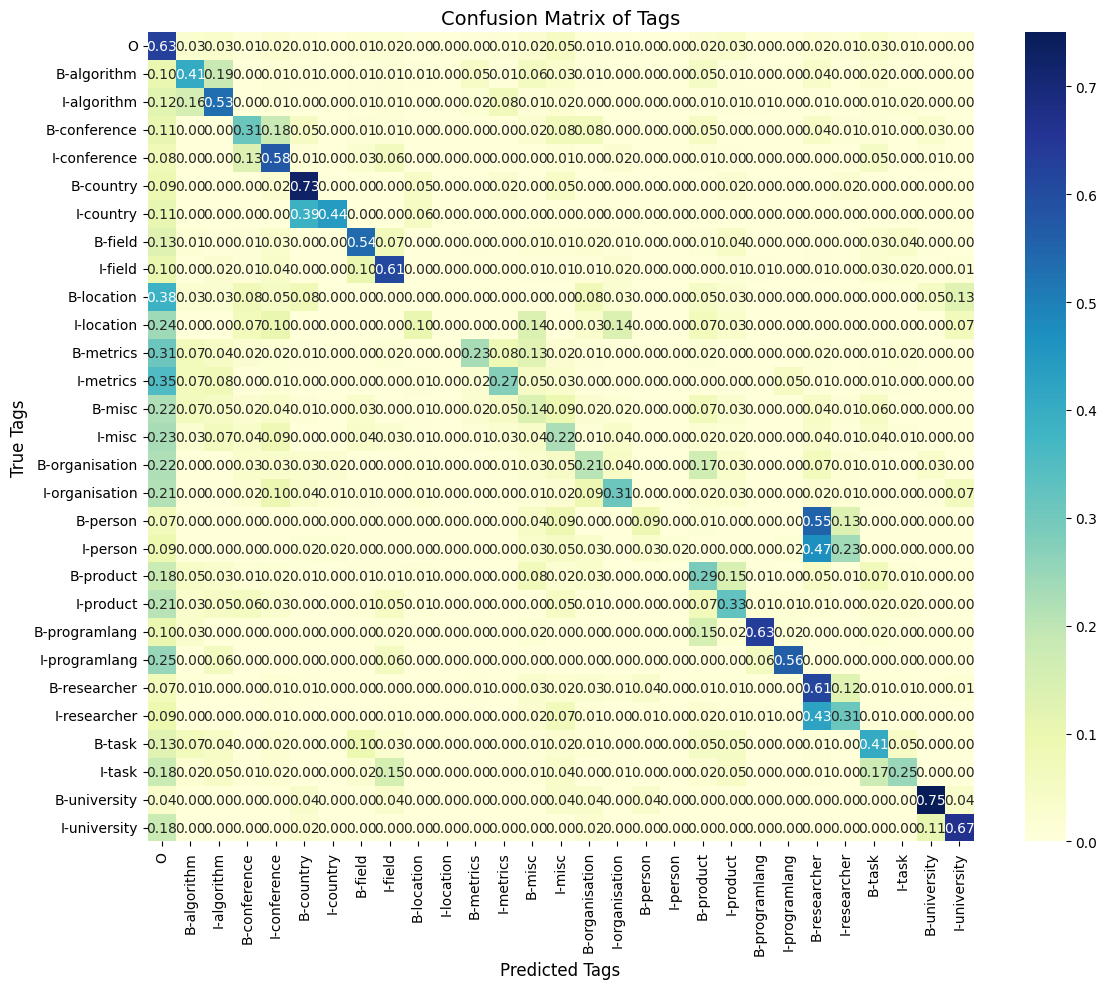

In [483]:
plot_confusion_matrix_of_tags(samples["total_count_lower"]["true"], samples["total_count_lower"]["false"], id2tag)

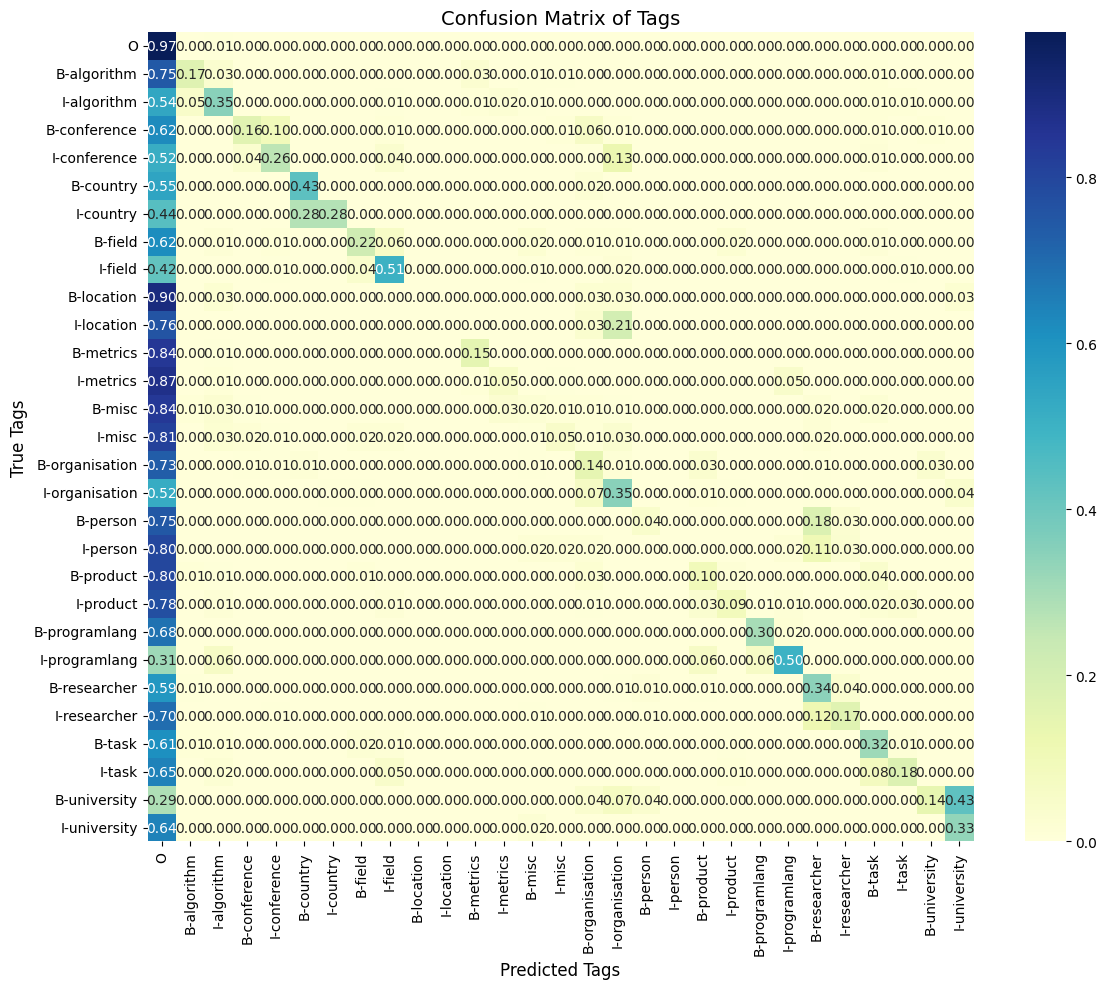

In [484]:
plot_confusion_matrix_of_tags(samples["simple_lower"]["true"], samples["simple_lower"]["false"], id2tag)

Вот что здесь важно: когда мы стремимся просто повышать точность - у нас все классы начинают предсказываться как O, что совсем не хорошо. Когда же мы акцентируем свое внимание на том, чтобы повышать F1 - мы видим проявляющуюся диагональ - что классы начинают с ошибками, но предсказываться корректно.

Еще мы здесь видим треугольники между в и и тегами - это говорит о том, что круче всего было бы обучить модель без разделения на эти теги.

## Save best model by metric f1 macro

In [489]:
def train_process(embedding_matrix, tokenizer, embedding_dim, encoded_datasets, criterion = None, field = "ai", comment = "1_count", learning_rate = 0.001, num_epochs = 10, current_model_class = BiLSTMTagger):
    model, device = init_model(tokenizer, embedding_matrix, current_model_class = current_model_class, embedding_dim = embedding_dim)

    if not criterion:
        criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_ID)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = TokenDataset(encoded_datasets["train"][field]["input_ids"], encoded_datasets["train"][field]["labels"])
    val_dataset = TokenDataset(encoded_datasets["val"][field]["input_ids"], encoded_datasets["val"][field]["labels"])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    best_val_f1 = -float('inf')  # Инициализация лучшего F1

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(input_ids)  # [batch_size, seq_len, num_tags]
            loss = criterion(logits.view(-1, NUM_TAGS), labels.view(-1))

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0
        all_true_tags = []
        all_pred_tags = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, labels = batch
                input_ids = input_ids.to(device)
                labels = labels.to(device)
                logits = model(input_ids)
                loss = criterion(logits.view(-1, NUM_TAGS), labels.view(-1))
                val_loss += loss.item()

                # Предсказания
                predictions = torch.argmax(logits, dim=-1) # [batch_size, seq_len]

                pred_tags_batch = predictions.cpu().numpy().flatten()
                true_tags_batch = labels.cpu().numpy().flatten()

                all_true_tags.extend(true_tags_batch)
                all_pred_tags.extend(pred_tags_batch)

        avg_val_loss = val_loss / len(val_loader)

        # Считаем f1-macro для валидационного сета
        import numpy as np
        from sklearn.metrics import f1_score

        all_true_tags = np.array(all_true_tags)
        all_pred_tags = np.array(all_pred_tags)

        # Исключаем паддинг из расчета метрик
        mask = all_true_tags != PAD_TAG_ID
        true_filtered = all_true_tags[mask]
        pred_filtered = all_pred_tags[mask]

        # Считаем f1_macro
        # Необходимо указать average='macro', zero_division=0 чтобы не было ошибок при отсутствии класса
        val_f1_macro = f1_score(true_filtered, pred_filtered, average='macro', zero_division=0)

        # Сохраняем модель, если улучшился результат по f1-macro
        if val_f1_macro > best_val_f1:
            best_val_f1 = val_f1_macro
            torch.save(model.state_dict(), MODEL_PATH.format(comment = comment))
            print(f"Epoch {epoch+1}/{num_epochs}: Val F1-macro improved to {val_f1_macro:.4f}. Model saved.")
        else:
            print(f"Epoch {epoch+1}/{num_epochs}: Val F1-macro did not improve from {best_val_f1:.4f}.")

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1-macro: {val_f1_macro:.4f}")


In [530]:
names = {
    "focal_2_save_by_f1_macro": focal_criterion,
    "simple_save_by_f1_macro": None,
    "1_count_save_by_f1_macro": get_pos_weight("1_count_save_by_f1_macro"),
    "total_count_save_by_f1_macro": get_pos_weight("1_count_save_by_f1_macro"),
}

for name, func in names.items():
    print(f" TRAIN  {name}")

    # if func:
    #     criterion = func
    #     train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = func, field="ai", comment=name + "_lower", num_epochs=50)

    # else:
    #     train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = None, field="ai", comment=name + "_lower", num_epochs=50)


    samples[name + "_lower"] = generate_test_samples(encoded_datasets_lowercase, tokenizer_lower, embedding_matrix_lower, name + "_lower")


 TRAIN  focal_2_save_by_f1_macro
 TRAIN  simple_save_by_f1_macro
 TRAIN  1_count_save_by_f1_macro
 TRAIN  total_count_save_by_f1_macro


## 2 layer model

In [504]:
import torch
import torch.nn as nn

class BiLSTMTagger2Layer(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 num_tags, 
                 embedding_dim, 
                 hidden_dim, 
                 pad_token_id=0, 
                 pretrained_embeddings=None, 
                 freeze_embeddings=False,
                 dropout=0.3):
        super(BiLSTMTagger2Layer, self).__init__()
        self.num_tags = num_tags
        print("Init 2 layer lstm")

        # Эмбеддинги
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id)
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id)

        # Дропаут на эмбеддингах
        self.embed_dropout = nn.Dropout(dropout)

        # Двухслойный БиLSTM с дропаутом
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # BatchNorm по скрытым состояниям LSTM
        self.bn = nn.BatchNorm1d(hidden_dim * 2)

        # Нелинейная активация перед выходным слоем
        self.activation = nn.ReLU()

        # Выходной слой
        self.fc = nn.Linear(hidden_dim*2, num_tags)

    def forward(self, input_ids):
        # [batch_size, seq_len] -> [batch_size, seq_len, embedding_dim]
        embeds = self.embedding(input_ids)
        embeds = self.embed_dropout(embeds)

        # LSTM
        outputs, _ = self.lstm(embeds)  # [batch_size, seq_len, hidden_dim*2]

        # Применим BatchNorm:
        # Преобразуем [batch_size, seq_len, feature_dim] -> [batch_size*seq_len, feature_dim]
        batch_size, seq_len, feature_dim = outputs.shape
        outputs_2d = outputs.reshape(-1, feature_dim)
        outputs_bn = self.bn(outputs_2d)
        outputs_bn = outputs_bn.reshape(batch_size, seq_len, feature_dim)

        # Нелинейная активация
        outputs_act = self.activation(outputs_bn)

        # Логиты
        logits = self.fc(outputs_act)  # [batch_size, seq_len, num_tags]
        return logits


In [528]:
names = {
    "focal_2_save_by_f1_macro_2layers": focal_criterion,
    "simple_save_by_f1_macro_2layers": None,
    "1_count_save_by_f1_macro_2layers": get_pos_weight("1_count_save_by_f1_macro"),
    "total_save_by_f1_macro_2layers": get_pos_weight("1_count_save_by_f1_macro"),
}

for name, func in names.items():
    print(f" TRAIN  {name}")

    # if func:
    #     criterion = func
    #     train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = func, field="ai", comment=name + "_lower", num_epochs=50, current_model_class=BiLSTMTagger2Layer)

    # else:
    #     train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = None, field="ai", comment=name + "_lower", num_epochs=50, current_model_class=BiLSTMTagger2Layer)


    samples[name + "_lower"] = generate_test_samples(encoded_datasets_lowercase, tokenizer_lower, embedding_matrix_lower, name + "_lower", current_model_class=BiLSTMTagger2Layer )

 TRAIN  focal_2_save_by_f1_macro_2layers
Init 2 layer lstm
 TRAIN  simple_save_by_f1_macro_2layers
Init 2 layer lstm
 TRAIN  1_count_save_by_f1_macro_2layers
Init 2 layer lstm
 TRAIN  total_save_by_f1_macro_2layers
Init 2 layer lstm


## general metrics

Обьясняем: lower - обозначение того, что у нас только lowercase тип, а simple, focal_2, total_count и 1_count - это разные типы лоссов, где Simple - это обычная кросс энтропия, total_count и 1_count это взвешенная кросс энтропия с разными коэффициентами

focal_2 - другой тип лосса.

In [533]:
get_results(samples)

accuracy  precision_macro  \
simple_lower                            0.738896         0.423617   
simple                                  0.548380         0.220981   
focal_2_lower                           0.738819         0.535418   
focal_2                                 0.738357         0.339223   
total_count_lower                       0.552075         0.291052   
total_count                             0.591563         0.241053   
1_count_lower                           0.572011         0.233286   
1_count                                 0.583866         0.228716   
focal_2_save_by_f1_macro_lower          0.745054         0.461689   
simple_save_by_f1_macro_lower           0.750058         0.461746   
focal_2_save_by_f1_macro_2layers_lower  0.753291         0.520149   
simple_save_by_f1_macro_2layers_lower   0.758140         0.462358   
1_count_save_by_f1_macro_2layers_lower  0.708490         0.370921   
total_save_by_f1_macro_2layers_lower    0.670618         0.320029   
1_count_save_by_f1_macro_lower          0.691941         0.335162   
total_count_save_by_f1_macro_lower      0.710184         0.373394   

                                        recall_macro  f1_macro  
simple_lower                                0.282322  0.313261  
simple                                      0.338453  0.243499  
focal_2_lower                               0.171579  0.231200  
focal_2                                     0.153696  0.189412  
total_count_lower                           0.381757  0.285160  
total_count                                 0.304471  0.248484  
1_count_lower                               0.376778  0.270190  
1_count                                     0.315007  0.239533  
focal_2_save_by_f1_macro_lower              0.279094  0.322343  
simple_save_by_f1_macro_lower               0.286242  0.323967  
focal_2_save_by_f1_macro_2layers_lower      0.285602  0.340704  
simple_save_by_f1_macro_2layers_lower       0.333537  0.361815  
1_count_save_by_f1_macro_2layers_lower      0.364525  0.344443  
total_save_by_f1_macro_2layers_lower        0.368263  0.319893  
1_count_save_by_f1_macro_lower              0.353487  0.327521  
total_count_save_by_f1_macro_lower          0.336982  0.324463

видно, что лучшей моделькой по метрике F1 является 2-слойная бидирекционная LSTM, в которой мы применили простой лосс, сохраняли на основе метрики f1, и брали только ловеркейс токены

Значения `simple_save_by_f1_macro_2layers_lower` так же сравнимы с самыми первыми замерами по точности, но все остальные метрики выросли.

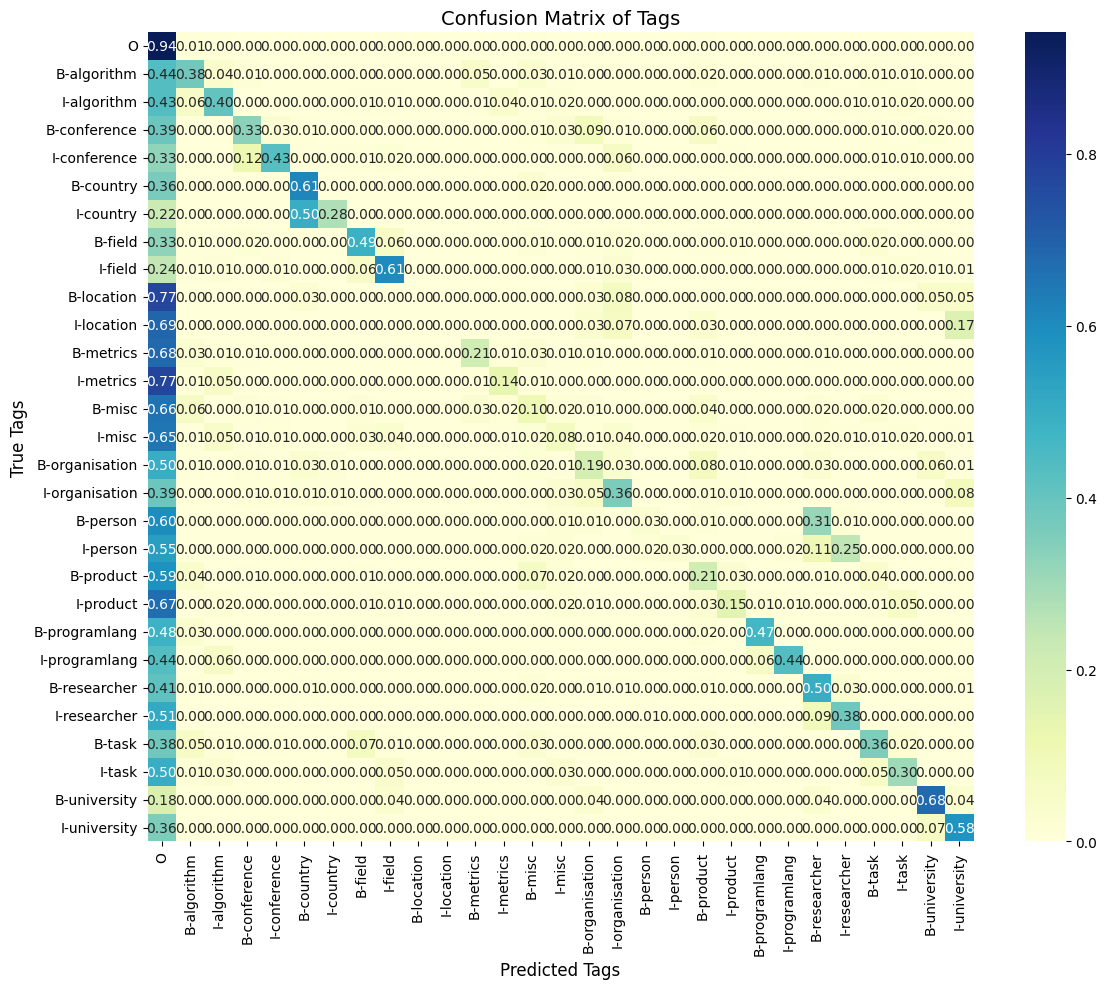

In [539]:
plot_confusion_matrix_of_tags(samples["simple_save_by_f1_macro_2layers_lower"]["true"], samples["simple_save_by_f1_macro_2layers_lower"]["false"], id2tag)

Мы смогли повысить метрику, однако как нам нравился O класс, так он нам и нравится

## Best model not in B-I notation

Возможно, переход к просто тегам без B и I нотации поможет нам повысить качество:

In [540]:
# Получаем список всех тегов (кроме паддинга и O мы удаляем префиксы B- I-):
unique_short_tags = set()
for t in tag2id.keys():
    if t in ["O", "<PAD>"]:
        short_tag = t
    else:
        # Удаляем префикс B- или I-
        short_tag = t.split('-', 1)[1]  # Разделяем по первому дефису
    unique_short_tags.add(short_tag)

unique_short_tags = sorted(list(unique_short_tags))  # Сортируем для консистентности

# Формируем новые словари
tag2id_short = {t: i for i, t in enumerate(unique_short_tags)}
id2tag_short = {i: t for t, i in tag2id_short.items()}

print("tag2id_short:", tag2id_short)
print("id2tag_short:", id2tag_short)

tag2id_short: {'<PAD>': 0, 'O': 1, 'academicjournal': 2, 'album': 3, 'algorithm': 4, 'astronomicalobject': 5, 'award': 6, 'band': 7, 'book': 8, 'chemicalcompound': 9, 'chemicalelement': 10, 'conference': 11, 'country': 12, 'discipline': 13, 'election': 14, 'enzyme': 15, 'event': 16, 'field': 17, 'literarygenre': 18, 'location': 19, 'magazine': 20, 'metrics': 21, 'misc': 22, 'musicalartist': 23, 'musicalinstrument': 24, 'musicgenre': 25, 'organisation': 26, 'person': 27, 'poem': 28, 'politicalparty': 29, 'politician': 30, 'product': 31, 'programlang': 32, 'protein': 33, 'researcher': 34, 'scientist': 35, 'song': 36, 'task': 37, 'theory': 38, 'university': 39, 'writer': 40}
id2tag_short: {0: '<PAD>', 1: 'O', 2: 'academicjournal', 3: 'album', 4: 'algorithm', 5: 'astronomicalobject', 6: 'award', 7: 'band', 8: 'book', 9: 'chemicalcompound', 10: 'chemicalelement', 11: 'conference', 12: 'country', 13: 'discipline', 14: 'election', 15: 'enzyme', 16: 'event', 17: 'field', 18: 'literarygenre', 1

In [543]:
def convert_tag_to_short(t):
    if t in ["O", "<PAD>"]:
        return t
    else:
        return t.split('-', 1)[1]

def get_lowercase_tokens(example):
    return {"tags_short": [tag2id_short[convert_tag_to_short(tag)] for tag in example["tags_named"]]}

for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].map(get_lowercase_tokens)

Map:   0%|          | 0/14741 [00:00<?, ? examples/s]

Map: 100%|██████████| 5959/5959 [00:00<00:00, 7638.54 examples/s] 


In [547]:
def encode_tags(dataset, max_len, pad_tag_id=0):
    encoded_tags = []
    for tags in dataset["tags_short"]:
        # Если длина больше max_len, обрезаем
        if len(tags) > max_len:
            encoded = tags[:max_len]
        else:
            # Если длина меньше max_len, добавляем паддинг с использованием pad_tag_id
            encoded = tags + [pad_tag_id] * (max_len - len(tags))
        encoded_tags.append(encoded)
    return np.array(encoded_tags)

PAD_TAG_ID = 0
NUM_TAGS = len(tag2id_short)

In [546]:
encoded_datasets_lowercase = get_tokenized_data()

Обработка по сплиту:   0%|          | 0/3 [00:00<?, ?it/s]







Filter: 100%|██████████| 14741/14741 [00:00<00:00, 15202.38 examples/s]








Filter: 100%|██████████| 14741/14741 [00:00<00:00, 15224.17 examples/s]








Filter: 100%|██████████| 14741/14741 [00:01<00:00, 11230.00 examples/s]








Filter: 100%|██████████| 14741/14741 [00:00<00:00, 15191.29 examples/s]








Filter: 100%|██████████| 14741/14741 [00:01<00:00, 14468.46 examples/s]








Обработка по сплиту:  33%|███▎      | 1/3 [00:07<00:15,  7.52s/it]



Filter: 100%|██████████| 5371/5371 [00:00<00:00, 10739.83 examples/s]



Filter: 100%|██████████| 5371/5371 [00:00<00:00, 11362.29 examples/s]



Filter: 100%|██████████| 5371/5371 [00:00<00:00, 11044.31 examples/s]




Filter: 100%|██████████| 5371/5371 [00:00<00:00, 10546.70 examples/s]




Filter: 100%|██████████| 5371/5371 [00:00<00:00, 10657.22 examples/s]




Обработка по сплиту:  67%|██████▋   | 2/3 [00:10<00:05,  5.13s/it]



Filter: 100%|██████████| 5

In [548]:
name = "simple_save_by_f1_macro_2layers"
train_process(embedding_matrix_lower, tokenizer_lower, embedding_dim, encoded_datasets = encoded_datasets_lowercase, criterion = None, field="ai", comment=name + "_lower", num_epochs=50, current_model_class=BiLSTMTagger2Layer)

Init 2 layer lstm
Epoch 1/50: Val F1-macro improved to 0.1546. Model saved.
Epoch 1/50, Train Loss: 2.2536, Val Loss: 3.4775, Val F1-macro: 0.1546
Epoch 2/50: Val F1-macro did not improve from 0.1546.
Epoch 2/50, Train Loss: 1.0692, Val Loss: 3.2564, Val F1-macro: 0.1536
Epoch 3/50: Val F1-macro improved to 0.2346. Model saved.
Epoch 3/50, Train Loss: 0.9631, Val Loss: 3.0190, Val F1-macro: 0.2346
Epoch 4/50: Val F1-macro improved to 0.2637. Model saved.
Epoch 4/50, Train Loss: 0.7710, Val Loss: 2.6817, Val F1-macro: 0.2637
Epoch 5/50: Val F1-macro improved to 0.3055. Model saved.
Epoch 5/50, Train Loss: 0.6946, Val Loss: 2.4935, Val F1-macro: 0.3055
Epoch 6/50: Val F1-macro did not improve from 0.3055.
Epoch 6/50, Train Loss: 0.6737, Val Loss: 2.1736, Val F1-macro: 0.2650
Epoch 7/50: Val F1-macro did not improve from 0.3055.
Epoch 7/50, Train Loss: 0.6172, Val Loss: 1.9409, Val F1-macro: 0.2992
Epoch 8/50: Val F1-macro did not improve from 0.3055.
Epoch 8/50, Train Loss: 0.5592, Val L

In [550]:
samples[name + "_lower_short_tag"] = generate_test_samples(encoded_datasets_lowercase, tokenizer_lower, embedding_matrix_lower, name + "_lower", current_model_class=BiLSTMTagger2Layer )

Init 2 layer lstm


In [551]:
get_results(samples)

accuracy  precision_macro  \
simple_lower                                     0.738896         0.423617   
simple                                           0.548380         0.220981   
focal_2_lower                                    0.738819         0.535418   
focal_2                                          0.738357         0.339223   
total_count_lower                                0.552075         0.291052   
total_count                                      0.591563         0.241053   
1_count_lower                                    0.572011         0.233286   
1_count                                          0.583866         0.228716   
focal_2_save_by_f1_macro_lower                   0.745054         0.461689   
simple_save_by_f1_macro_lower                    0.750058         0.461746   
focal_2_save_by_f1_macro_2layers_lower           0.753291         0.520149   
simple_save_by_f1_macro_2layers_lower            0.758140         0.462358   
1_count_save_by_f1_macro_2layers_lower           0.708490         0.370921   
total_save_by_f1_macro_2layers_lower             0.670618         0.320029   
1_count_save_by_f1_macro_lower                   0.691941         0.335162   
total_count_save_by_f1_macro_lower               0.710184         0.373394   
simple_save_by_f1_macro_2layers_lower_short_tag  0.180032         0.406042   

                                                 recall_macro  f1_macro  
simple_lower                                         0.282322  0.313261  
simple                                               0.338453  0.243499  
focal_2_lower                                        0.171579  0.231200  
focal_2                                              0.153696  0.189412  
total_count_lower                                    0.381757  0.285160  
total_count                                          0.304471  0.248484  
1_count_lower                                        0.376778  0.270190  
1_count                                              0.315007  0.239533  
focal_2_save_by_f1_macro_lower                       0.279094  0.322343  
simple_save_by_f1_macro_lower                        0.286242  0.323967  
focal_2_save_by_f1_macro_2layers_lower               0.285602  0.340704  
simple_save_by_f1_macro_2layers_lower                0.333537  0.361815  
1_count_save_by_f1_macro_2layers_lower               0.364525  0.344443  
total_save_by_f1_macro_2layers_lower                 0.368263  0.319893  
1_count_save_by_f1_macro_lower                       0.353487  0.327521  
total_count_save_by_f1_macro_lower                   0.336982  0.324463  
simple_save_by_f1_macro_2layers_lower_short_tag      0.375304  0.362679

Но НЕТ)

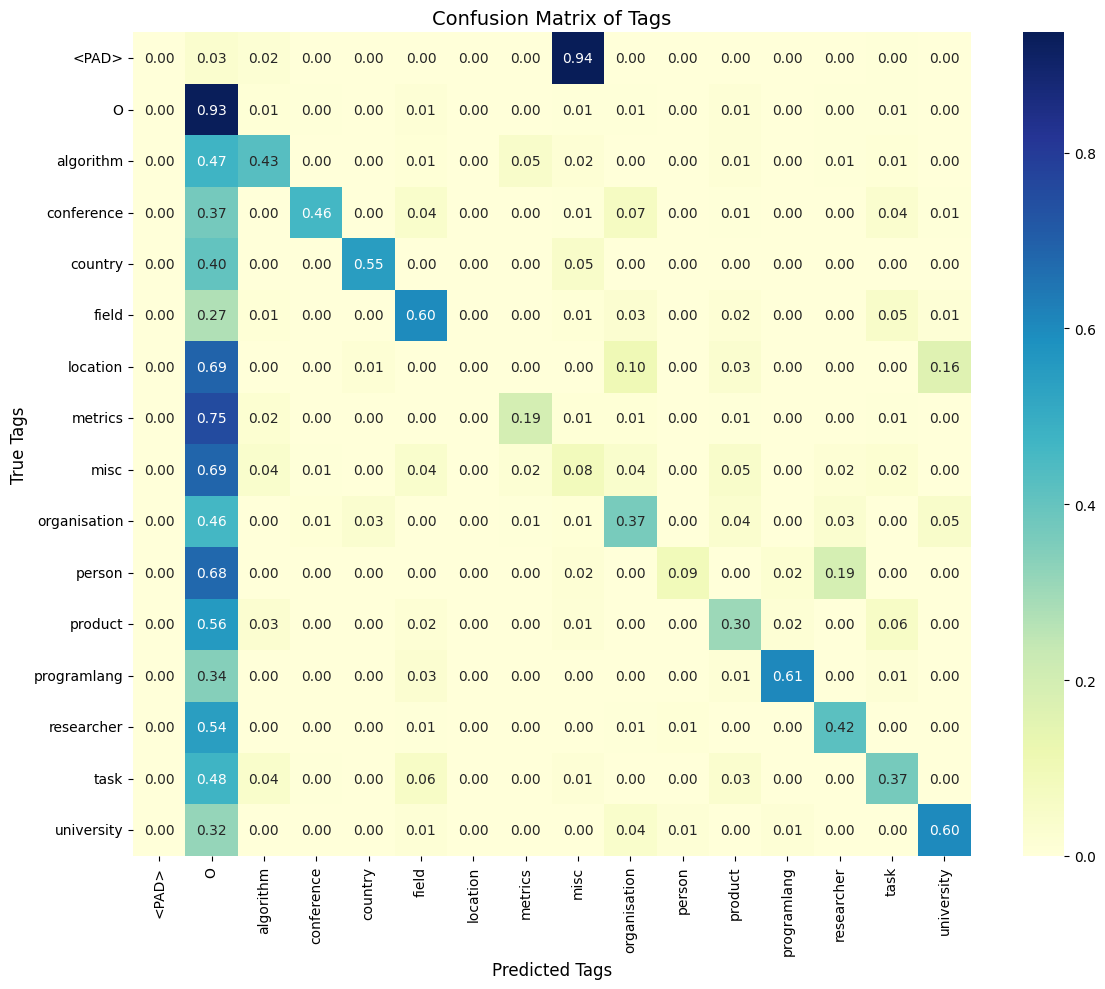

In [552]:
plot_confusion_matrix_of_tags(samples["simple_save_by_f1_macro_2layers_lower_short_tag"]["true"], samples["simple_save_by_f1_macro_2layers_lower_short_tag"]["false"], id2tag_short)

Нам все еще нравится О класс)

Выводы: 

Таким образом, с точки зрения метрик нам удалось с помощью нейронных подходов сильно повысить метрики F1, precision, recall, не уронив уровня точности.

Основная проблема, которую мы пытались пофиксить - сильная любовь к О.

Основной анализ методов проводился на ai домене, потому что его достаточно было для анализа (он и так получился большим)

Лучшим методом оказалась 2слойная LSTM бидирекционная с батч нормализацией, где мы привели наш текст к ловеркейсу и снизили процент рандомного инициализируемых эмбеддингов, которые мы потом учили. Тут можно делать бесконечно много всяких деталей, но две недели для супер фундаментального анализа не хватит даже если не работать)))) 